In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import itertools
import statsmodels.stats.multitest as mult
import os, sys
import argparse
import collections
import warnings
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d, Axes3D
warnings.filterwarnings("ignore")

### Here are two plotting functions

In [18]:
def plot_group_boxplot_y(file_name, y , y_labl, title_suffix, is_go_related):
    '''
    :param file_name: the name of the summary_ file in this directory.
    :param y: Which value is to be plotted on the box plots (Please refer to the following code blocks...)
    :param y_labl: The label of y-axis.
    :param title_suffix: The later part of the title of each plot. According to the situation if the information is GO-term related,
                                       The title will be added with the ontology at the front of the suffix.
    :param is_go_related: Boolean, whether this part of the analysis is GO-term related.
    '''
    #Read in the CSV file which contains the results of the analyses.
    df_homologs = pd.read_csv(file_name, sep='\t', index_col=0)
    
    #homolog_types are ortholog and paralog.
    homolog_types = np.unique(df_homologs['type'].values.tolist())
    
    # Set the colors of the boxplot for orthologs and paralogs.
    palette={Type: 'blue' if Type =='ortholog'  else 'crimson' for Type in np.unique(df_homologs['type']).tolist()}
    
    #Set the means as white dot and the notched box plots with the colors set above.
    ax=sns.boxplot(x="type", y=y, data=df_homologs.sort_values('type'), showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, notch=True, palette=palette)
    
    #Compute the mean and median for ortholog and paralog, respectively.
    medians = df_homologs.groupby(['type'])[y].median().values
    means=df_homologs.groupby(['type'])[y].mean().values
    
    #The following lines can be uncommented if you are interested with the statistics!
    '''
    print('Medians: [orthologs, paralogs]')
    print(medians)
    print('Means: [orthologs, paralogs]')
    print(means) '''
    
    #The following lines of codes conduct the independent Student-t test for the comparison whether 
    # the difference between the metric of orthologs and paralogs is significant.
    n = df_homologs.groupby(['type']).size().values #The number of samples in orthologs and paralogs
    orth= df_homologs.loc[df_homologs['type']=='ortholog'].dropna()[y].values
    para=df_homologs.loc[df_homologs['type']=='paralog'].dropna()[y].values
    s, p = stats.ttest_ind(orth, para)
    
    #These lines can be uncommented.
    '''
    print('Test statistics and p-value between the total distributions of orthologs and paralogs: ')
    print(s, p)'''
    
    #Convert the number of samples to String, so that it can be shown on the boxplots.
    n = [str(x) for x in n.tolist()]  
    
    #The following lines of codes show the number of samples on the boxplots
    pos = range(len(n))
    for tick,label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick], 1.3 , n[tick], horizontalalignment='center', size='large', color='k', weight='semibold', fontsize=20)
        
    #The following lines of codes show the red asterisk and the black horizontal bar if the comparison is significant.
    if p <= 0.05:
        x1, x2, yval, h= 0, 1, 1.1, 0.05
        ax.plot([x1, x1, x2, x2], [yval, yval+h, yval+h, yval], lw=1.5, c='k')
        ax.text((x1+x2)*.5, yval+0.02, '*', ha='center', va='bottom', color='r', fontsize=30)
        
    #Set the size of the ticks, label of x and y axes and the maximal y-value that can be shown in the plot.
    ax.tick_params(labelsize=17)    
    ax.set_ylabel(y_labl, fontsize=17)
    ax.set_xlabel('Homolog Type', fontsize=20)
    ax.set_ylim(top=1.4)
    
    '''
    According to the situation if the information is GO-term related, 
    The title will be added with the ontology at the front of the suffix.'''
    if is_go_related:
        ax.set_title(title_suffix, fontsize=25)
    else:
        ax.set_title(title_suffix.split(', ')[1], fontsize=25)

    return orth, para
    
    
def plot_group_boxplot_xy(file_name, x, x_labl, y, y_labl, title_suffix, is_go_related):
    '''
    :param file_name: the name of the summary_ file in this directory.
    :param x: Which value is to be plotted on the X-axis of the box plots (Please refer to the following code blocks...)
    :param x_labl: The label of x-axis.
    :param y: Which value is to be plotted on the box plots (Please refer to the following code blocks...)
    :param y_labl: The label of y-axis.
    :param title_suffix: The later part of the title of each plot. According to the situation if the information is GO-term related,
                                       The title will be added with the ontology at the front of the suffix.
    :param is_go_related: Boolean, whether this part of the analysis is GO-term related.
    '''
    x_axis=x
    y_axis=y
    df_homologs =  pd.read_csv(file_name, sep='\t', index_col=0).replace(to_replace=float('nan'), value=0)
    tmp_homologs=df_homologs.dropna()
    
    #The following lines can be uncommented if you are interested with the statistics!
    '''
    print('The correlation on the whole datasets: ')
    print(stats.pearsonr(tmp_homologs[x_axis], tmp_homologs[y_axis]))
    print('The correlation on the orthologs')
    print(stats.pearsonr(tmp_homologs.loc[tmp_homologs['type']=='ortholog'][x_axis], tmp_homologs.loc[tmp_homologs['type']=='ortholog'][y_axis]))
    print('The correlation on the paralogs')
    print(stats.pearsonr(tmp_homologs.loc[tmp_homologs['type']=='paralog'][x_axis], tmp_homologs.loc[tmp_homologs['type']=='paralog'][y_axis]))
    print('The pooled dataset with the x value greater than 0.7.')
    print(stats.pearsonr(tmp_homologs.loc[(tmp_homologs[x_axis] >= 0.7)][x_axis], tmp_homologs.loc[(tmp_homologs[x_axis] >= 0.7)][y_axis]))

    print('The correlation on the orthologs with x value greater than 0.7')
    print(stats.pearsonr(tmp_homologs.loc[(tmp_homologs['type']=='ortholog') & (tmp_homologs[x_axis] >= 0.7)][x_axis], tmp_homologs.loc[(tmp_homologs['type']=='ortholog')& (tmp_homologs[x_axis] >= 0.7)][y_axis]))
    print('The correlation on the paralogs with x value greater than 0.7')
    print(stats.pearsonr(tmp_homologs.loc[(tmp_homologs['type']=='paralog') & (tmp_homologs[x_axis] >= 0.7)][x_axis], tmp_homologs.loc[(tmp_homologs['type']=='paralog')& (tmp_homologs[x_axis] >= 0.7)][y_axis]))'''

    #Divide the x values to several bins.
    df_homologs[x_axis] = df_homologs[x_axis].apply(lambda x: 100*x)
    df_homologs[x_axis]=df_homologs[x_axis].apply(lambda x: math.floor(x/10.))
    
    #The homolog types are ortholog and paralog.
    homolog_types = np.unique(df_homologs['type'].values.tolist())
    
    #Make the ticks labels on the x-axis.
    labels=np.flip(['100', '[90, 100)', '[80, 90)', '[70, 80)', '[60, 70)', '[50, 60)', '[40, 50)', '[30, 40)', '[20, 30)', '[10, 20)', '[0, 10)']).tolist()
    
    #Sort the values according to the type of the homologs and the binned x-values.
    df_homologs=df_homologs.sort_values(['type', x_axis])
    
    
    tmp=df_homologs
    
    #If the whole Dataframe is empty, exit the program.
    if len(tmp.index)==0:
        return
    
    
    #I rename the column because of the several confusing error messages.
    tmp=tmp.rename(columns={'type': 'Type'})
    
    # Set the colors of the boxplots for orthologs and paralogs.
    palette={Type: 'blue' if Type =='ortholog'  else 'crimson' for Type in np.unique(df_homologs['type']).tolist()}
    
    #Set the means as white dot and the notched box plots with the colors set above.
    ax = sns.boxplot(x=x_axis, y=y_axis, hue="Type", data=tmp, showmeans=True,meanprops={"marker":"o",
                    "markerfacecolor":"white", 
                    "markeredgecolor":"black",
                    "markersize":"10"}, notch=True, palette=palette)
 
    #Count the number of samples for orthologs and paralogs for every bin of x-value.
    n = tmp.groupby(['Type',x_axis]).count().reset_index(level=x_axis)
    
    #This list collects the ticks parameter. Because sometimes there are some bins that are absent in the data.
    x_labels=[]
    
    
    #The later part of the title of each plot. According to the situation if the information is GO-term related
    #The title will be added with the ontology at the front of the suffix.
    
    if is_go_related:
        ax.set_title(title_suffix, fontsize=35) ###
    else:
        ax.set_title(title_suffix.split(', ')[1], fontsize=35) ###
        
    #Show the number of samples on the top of every figure.
    counter = 0
    for j in range(11):
        tmpj=n.loc[n[x_axis]==j]
        offset = -0.2
        counter1 = 0           
        for homolog in homolog_types:
            if homolog in tmpj.index:
                #For the sample number of large digits, the following lines prevent the overlapping of numbers shown on the plot.
                if counter1 %2:
                    height=1.25
                else:
                    height=1.2
                ax.annotate( str(tmpj[y_axis].loc[homolog])+'.', (counter+offset, height), color='k', fontsize=20)
            counter1 += 1    
            offset += 0.4
        #If there are data in this bin of x value.    
        if len(tmpj.values) !=0:
            #The bin will be shown on the x-axis
            x_labels.append(labels[j])
            # The following lines are prepared for the independent Student-t test.
            para=tmp.loc[tmp[x_axis]==j]
            para=para.loc[para['Type']=='paralog'][y_axis]
            orth=tmp.loc[tmp[x_axis]==j]
            orth=orth.loc[orth['Type']=='ortholog'][y_axis]
            
            #These parameters are set for the red asterisk and black bar to show the significance of the comparison.
            x1=counter-0.2
            x2=counter+0.2
            y, h = 1.1, 0.05
            
            #If both orthologs and paralogs have data, perform the independent Student-t test.
            if len(para) > 0 and len(orth) > 0:           
                s, p=stats.ttest_ind(orth.values, para.values)
                
                #If it is significant, the red asterisk and black bar will be shown.
                if p <= 0.05:
                    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
                    ax.text((x1+x2)*.5, 1.13, '*', ha='center', va='bottom', color='r', fontsize=30)
                        
                
            counter += 1 #Increment of tick position
     
    #Add legend, label of x and y axes and adjust the word size.
    ax.legend(loc='upper left', fontsize=20, bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(x_labl, fontsize=30) 
    ax.set_ylabel(y_labl, fontsize=30)
    
    #Allow some space for the number of the samples to be shown on the boxplots.
    ax.set_ylim(top=1.3)
    
    #Set the binned x-axis with the collected ticks
    ax.set_xticklabels(x_labels, fontsize=27)
    
    #Set the size of the ticks on the y-axis.
    ax.tick_params(axis='y', labelsize=27)
    
    
        

    




## Plot the necessary figures: 
## Here is only the demonstration how I plot the results of the analyses.
## Please refer to the result section of my thesis for the meaning of each figure.

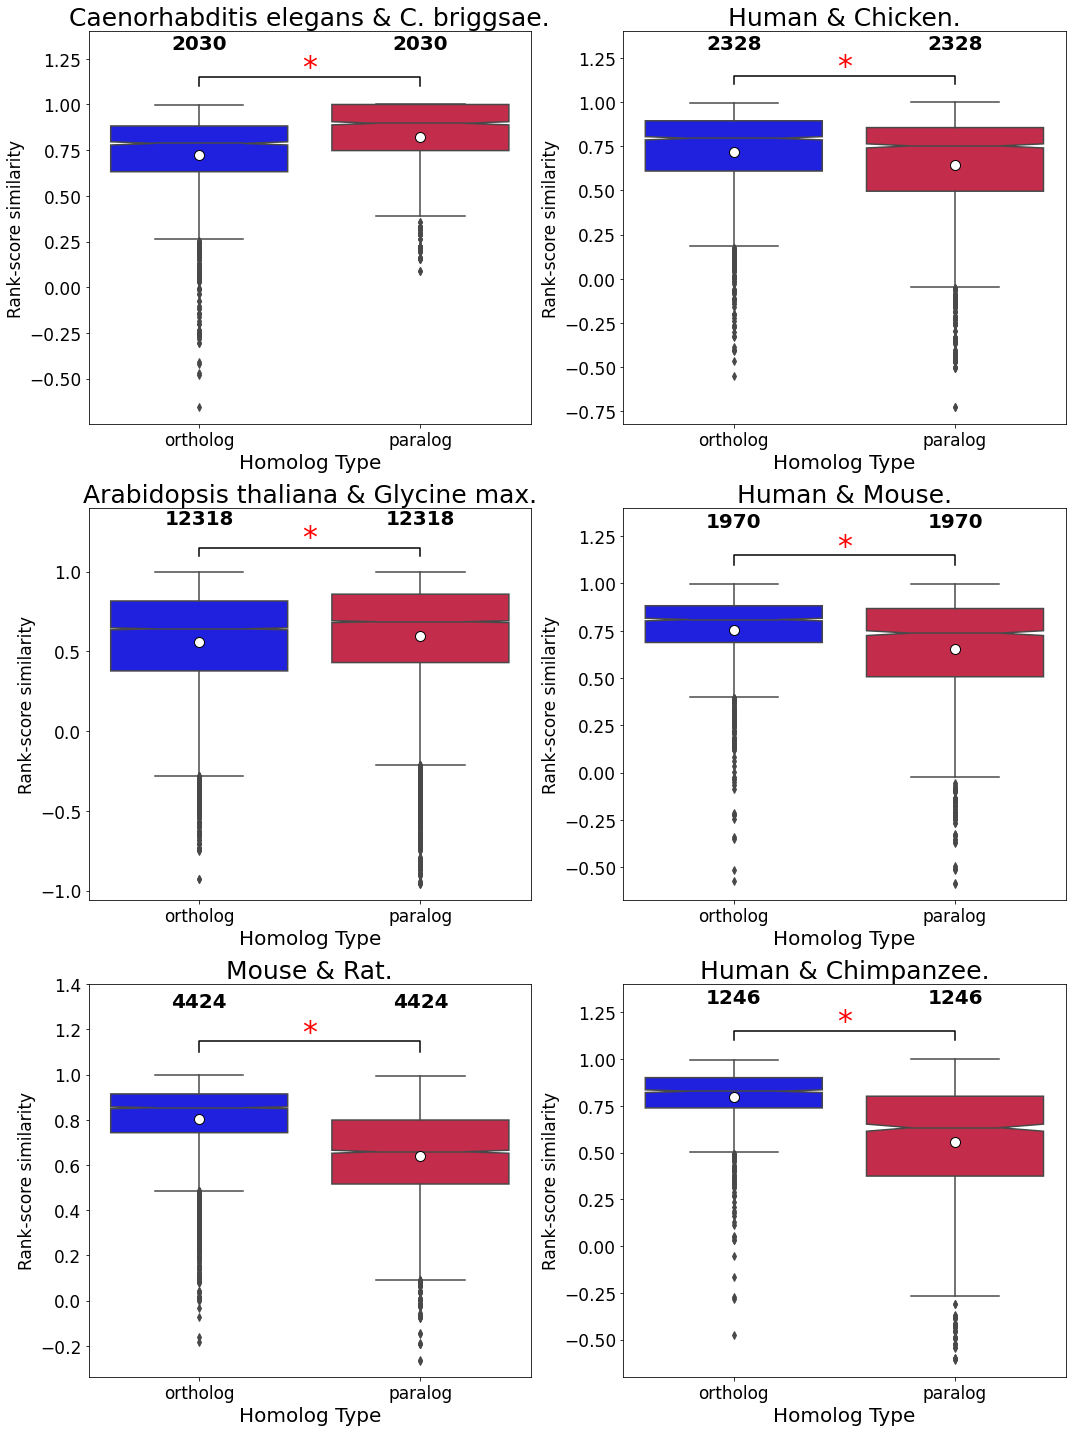

In [19]:
file_names=['summary_be.tsv',  'summary_hg.tsv', 'summary_ag.tsv', 'summary_hm.tsv', 'summary_soellner.tsv',  'summary_hc.tsv']
title_suffixes=[ ', Caenorhabditis elegans & C. briggsae.', ', Human & Chicken.',', Arabidopsis thaliana & Glycine max.',   ', Human & Mouse.',', Mouse & Rat.',  ', Human & Chimpanzee.']
counter = 0
fig=plt.figure(figsize=(15, 20))
for i in range(len(file_names)) :
    plt.subplot(3, 2, counter + 1)
    #print(file_names[i])
    plot_group_boxplot_y(file_names[i], 'r_sim',  'Rank-score similarity',  title_suffixes[i], False)
    counter += 1
    #print('------------------------------------')
    #print()
fig.tight_layout()
plt.savefig('div_time_r_sim.png')

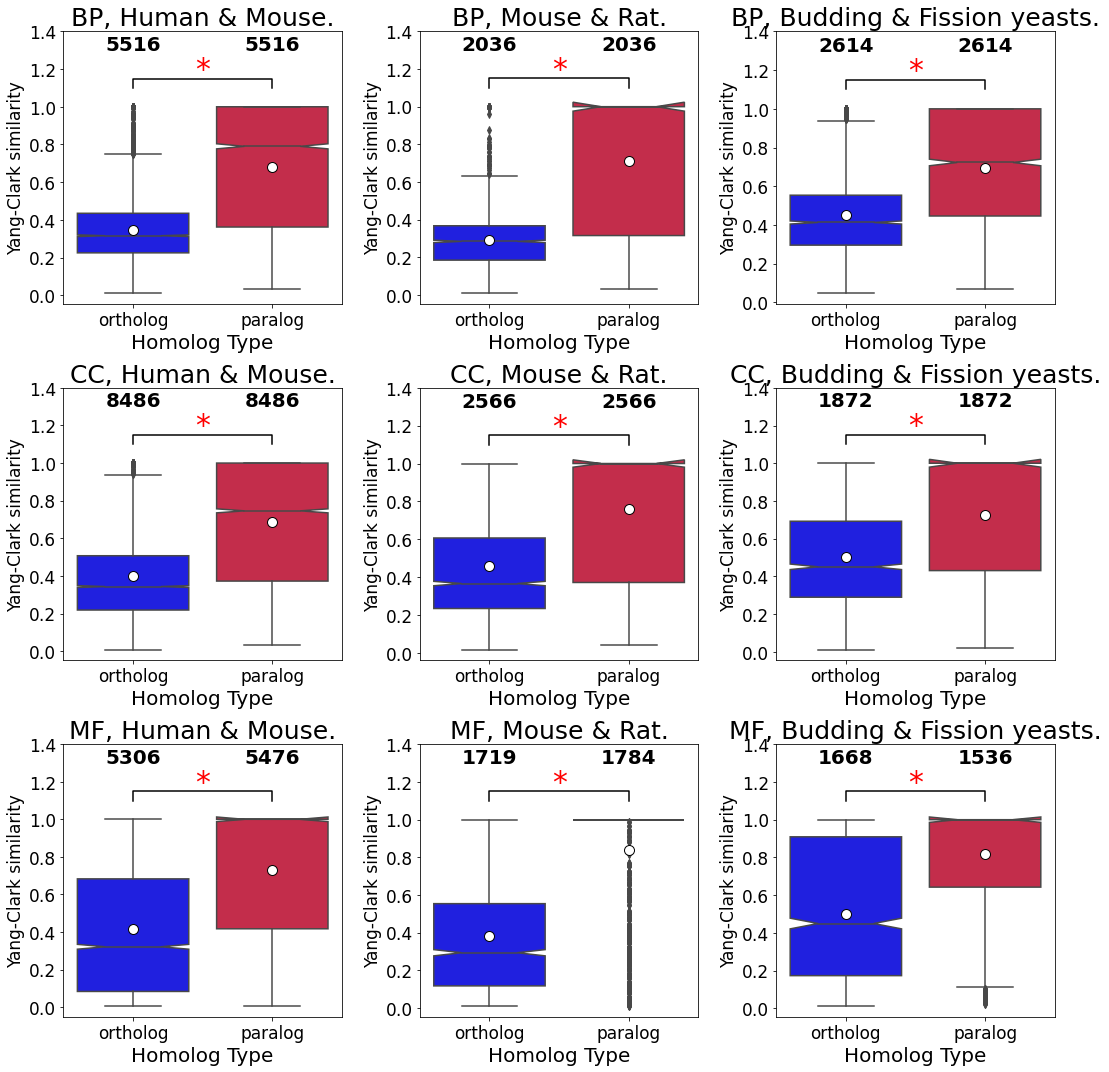

In [20]:
file_names=['summary_gos_hm_', 'summary_gos_mr_', 'summary_gos_cp_']
x='seq_iden'
ancs=['bp', 'cc', 'mf']
ancs_go=['BP', 'CC', 'MF']
x_labl='Sequence Identity'
y_labls=['Yang-Clark similarity', 'Schlicker similarity']
title_suffixes=[', Human & Mouse.',  ', Mouse & Rat.', ', Budding & Fission yeasts.']
counter = 0
fig=plt.figure(figsize=(15, 15))
for k in range(len(ancs)):
    for j in range(len(file_names)):
        plt.subplot(3, 3, counter + 1)
        tmp_file_name=file_names[j]+ancs[k]+'.tsv'
        #print(tmp_file_name)
        tmp_title_suffix= ancs_go[k]+title_suffixes[j]
        plot_group_boxplot_y(tmp_file_name, 'yc_sim', 'Yang-Clark similarity', tmp_title_suffix, True)
        counter += 1
        #print('--------------------------')
        #print()
fig.tight_layout()
plt.savefig('yc_sim3x3.png')

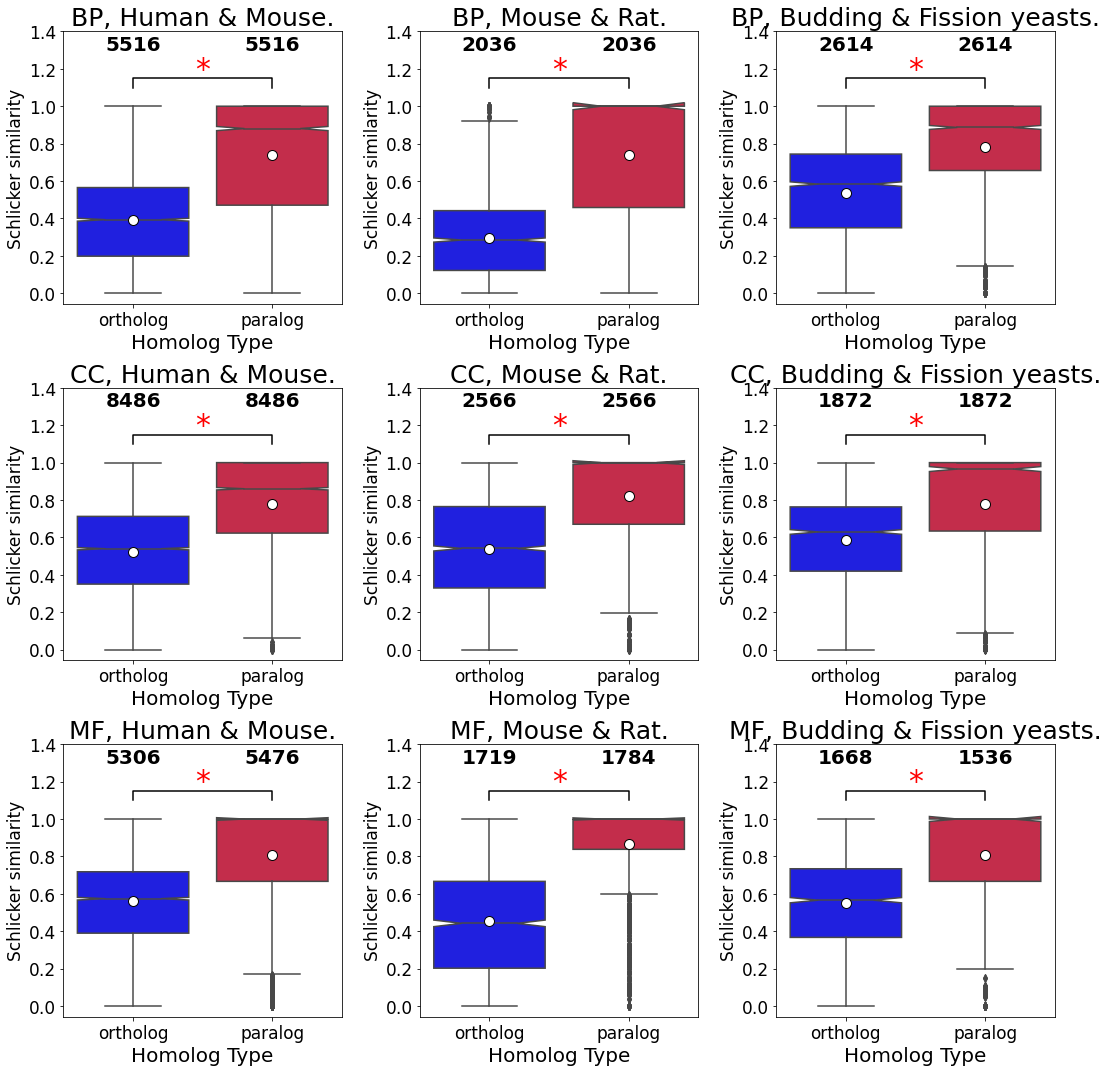

In [22]:
file_names=['summary_gos_hm_', 'summary_gos_mr_', 'summary_gos_cp_']
ancs=['bp', 'cc', 'mf']
ancs_go=['BP', 'CC', 'MF']
title_suffixes=[', Human & Mouse.',  ', Mouse & Rat.', ', Budding & Fission yeasts.']
counter = 0
fig=plt.figure(figsize=(15, 15))
for k in range(len(ancs)):
    for j in range(len(file_names)):
        plt.subplot(3, 3, counter + 1)
        tmp_file_name=file_names[j]+ancs[k]+'.tsv'
        #print(tmp_file_name)
        tmp_title_suffix= ancs_go[k]+title_suffixes[j]
        plot_group_boxplot_y(tmp_file_name, 'sc_sim', 'Schlicker similarity', tmp_title_suffix, True)
        counter += 1
        #print('----------------------')
        #print()
fig.tight_layout()
plt.savefig('sc_sim3x3.png')

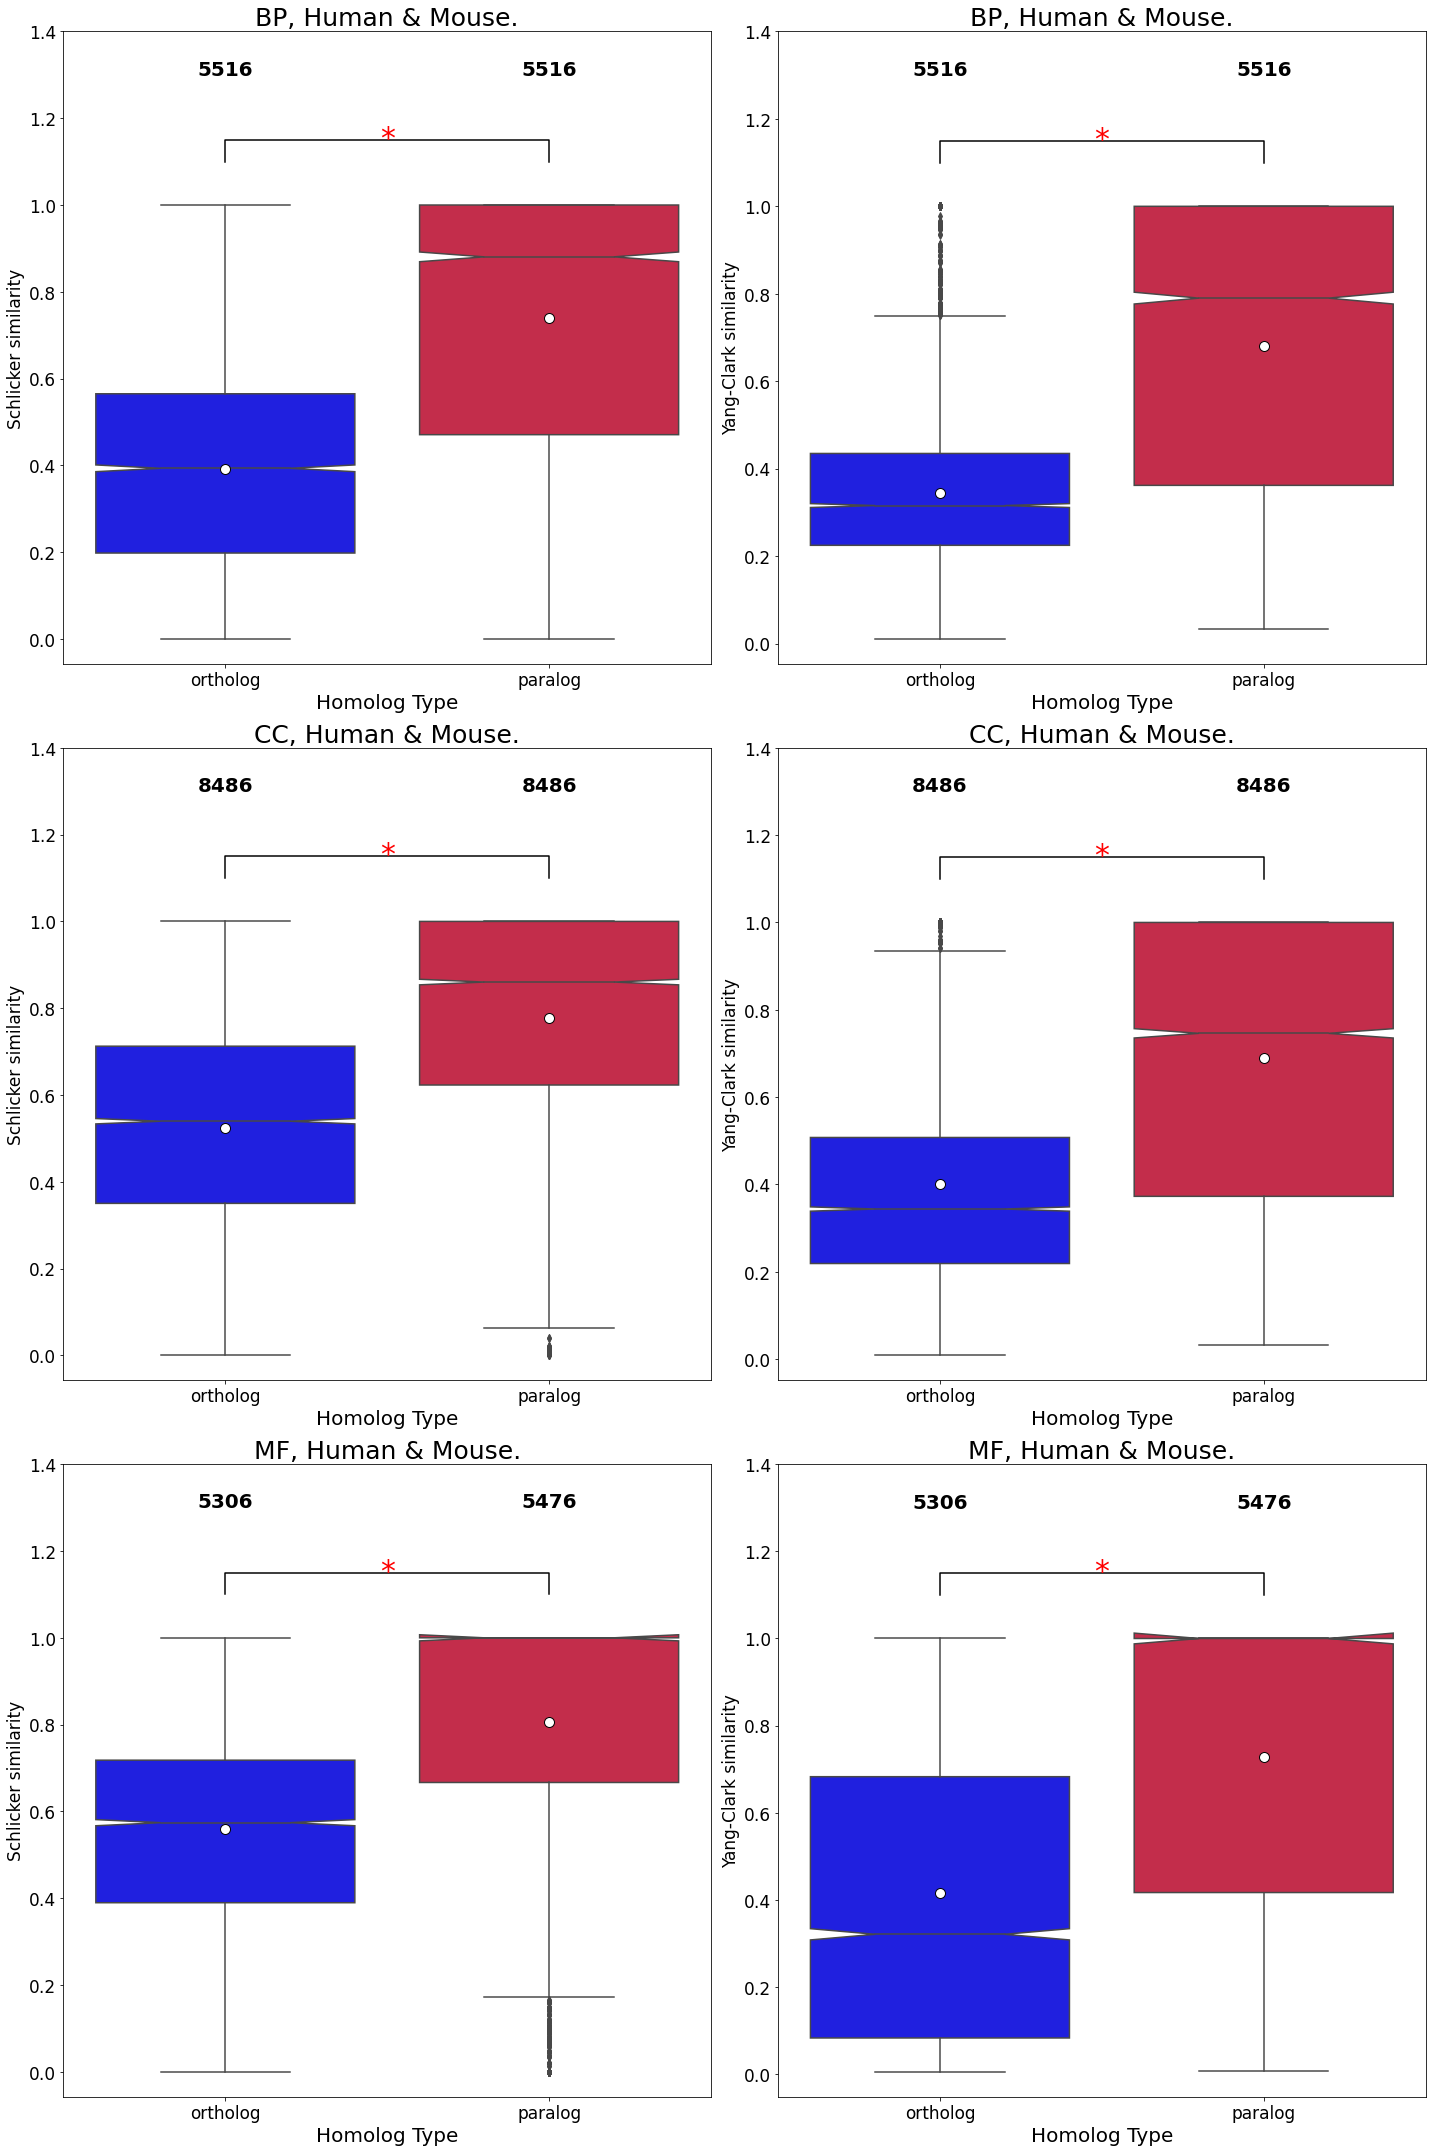

In [23]:
ancs=['bp', 'cc', 'mf']
ancs_go=['BP', 'CC', 'MF']
metrics =['sc_sim', 'yc_sim']
metrics_ylabels = ['Schlicker similarity', 'Yang-Clark similarity']
counter = 0
fig=plt.figure(figsize=(20, 30))

for i in range(len(ancs)):
    for j in range(len(metrics)):
        plt.subplot(3, 2, counter + 1)
        plot_group_boxplot_y('summary_gos_hm_'+ancs[i]+'.tsv', metrics[j], metrics_ylabels[j], ancs_go[i]+', Human & Mouse.', True)
        counter += 1


fig.tight_layout()
plt.savefig('sc_vs_yc.png')

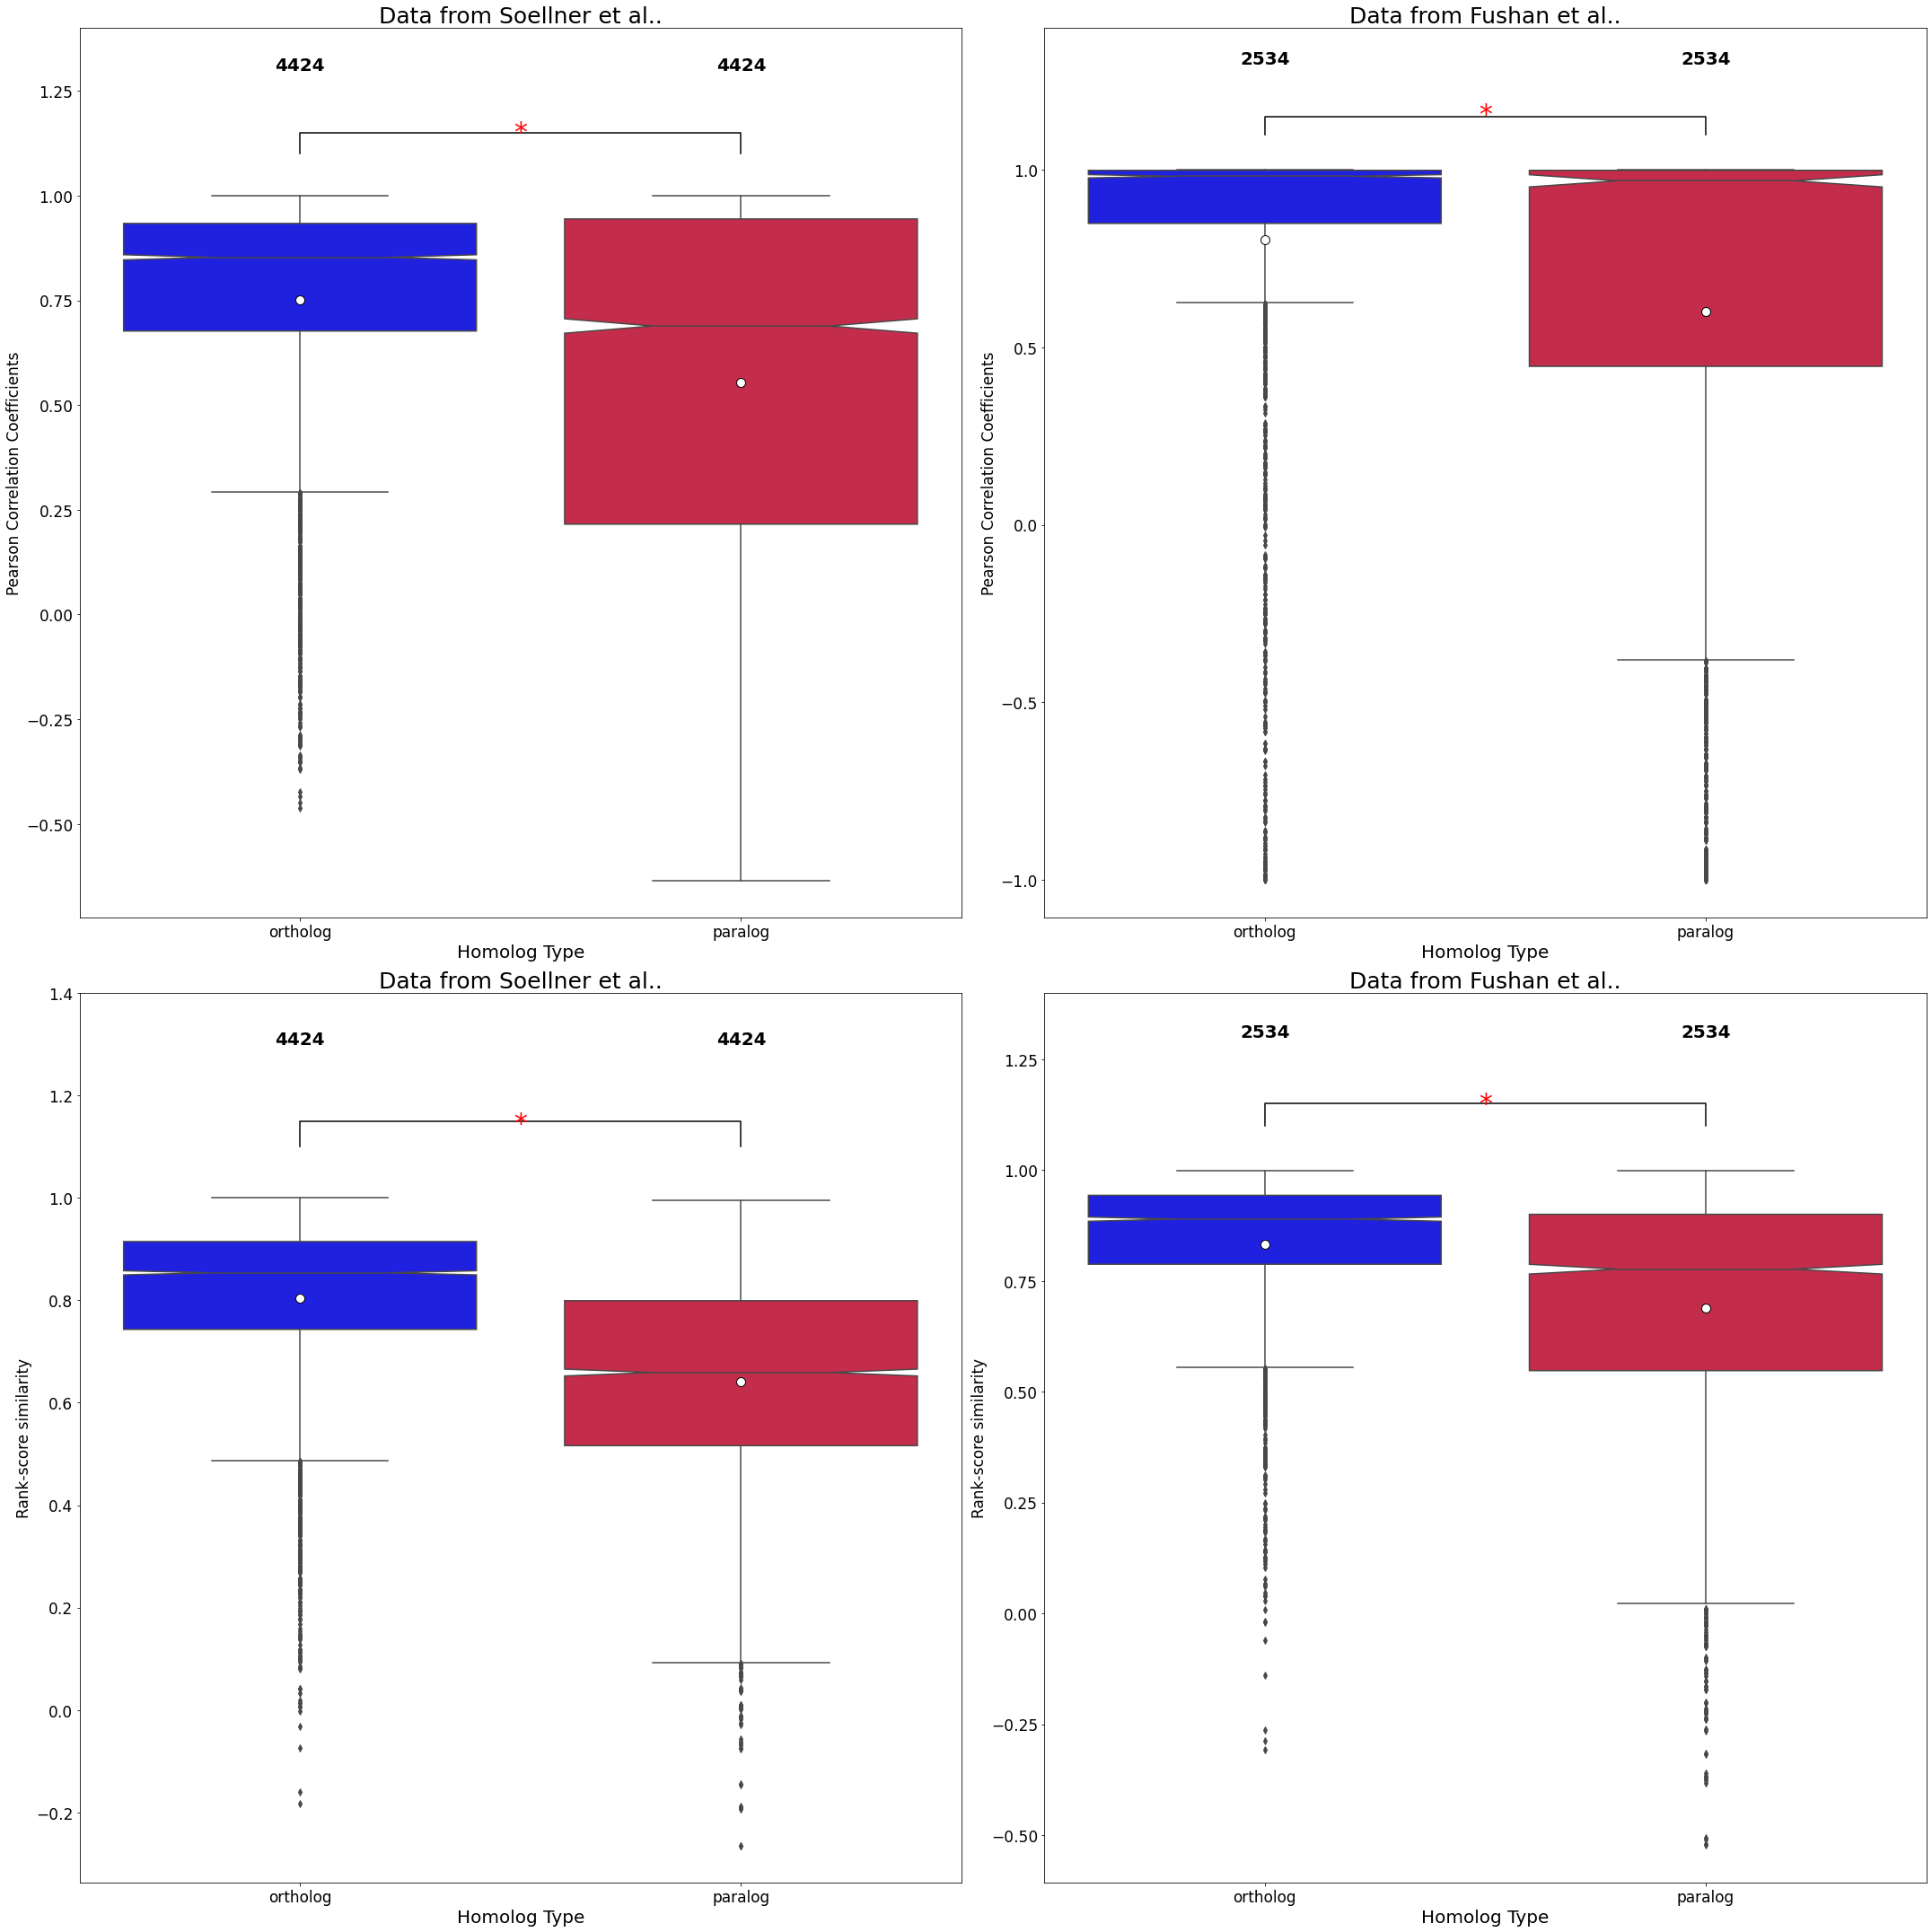

In [24]:
metrics=['p_corr', 'r_sim']
metrics_ylabels=['Pearson Correlation Coefficients', 'Rank-score similarity']
title_suffixes=[', Data from Soellner et al..',  ', Data from Fushan et al..']
file_names = ['summary_soellner.tsv', 'summary_fushan.tsv']
counter = 0
fig=plt.figure(figsize=(30, 30))
for i in range(len(metrics)):
    for j in range(len(file_names)):
        plt.subplot(2, 2, counter + 1)
        plot_group_boxplot_y(file_names[j], metrics[i], metrics_ylabels[i], title_suffixes[j], False)
        counter += 1
        
fig.tight_layout()
plt.savefig('long_vs_short.png')

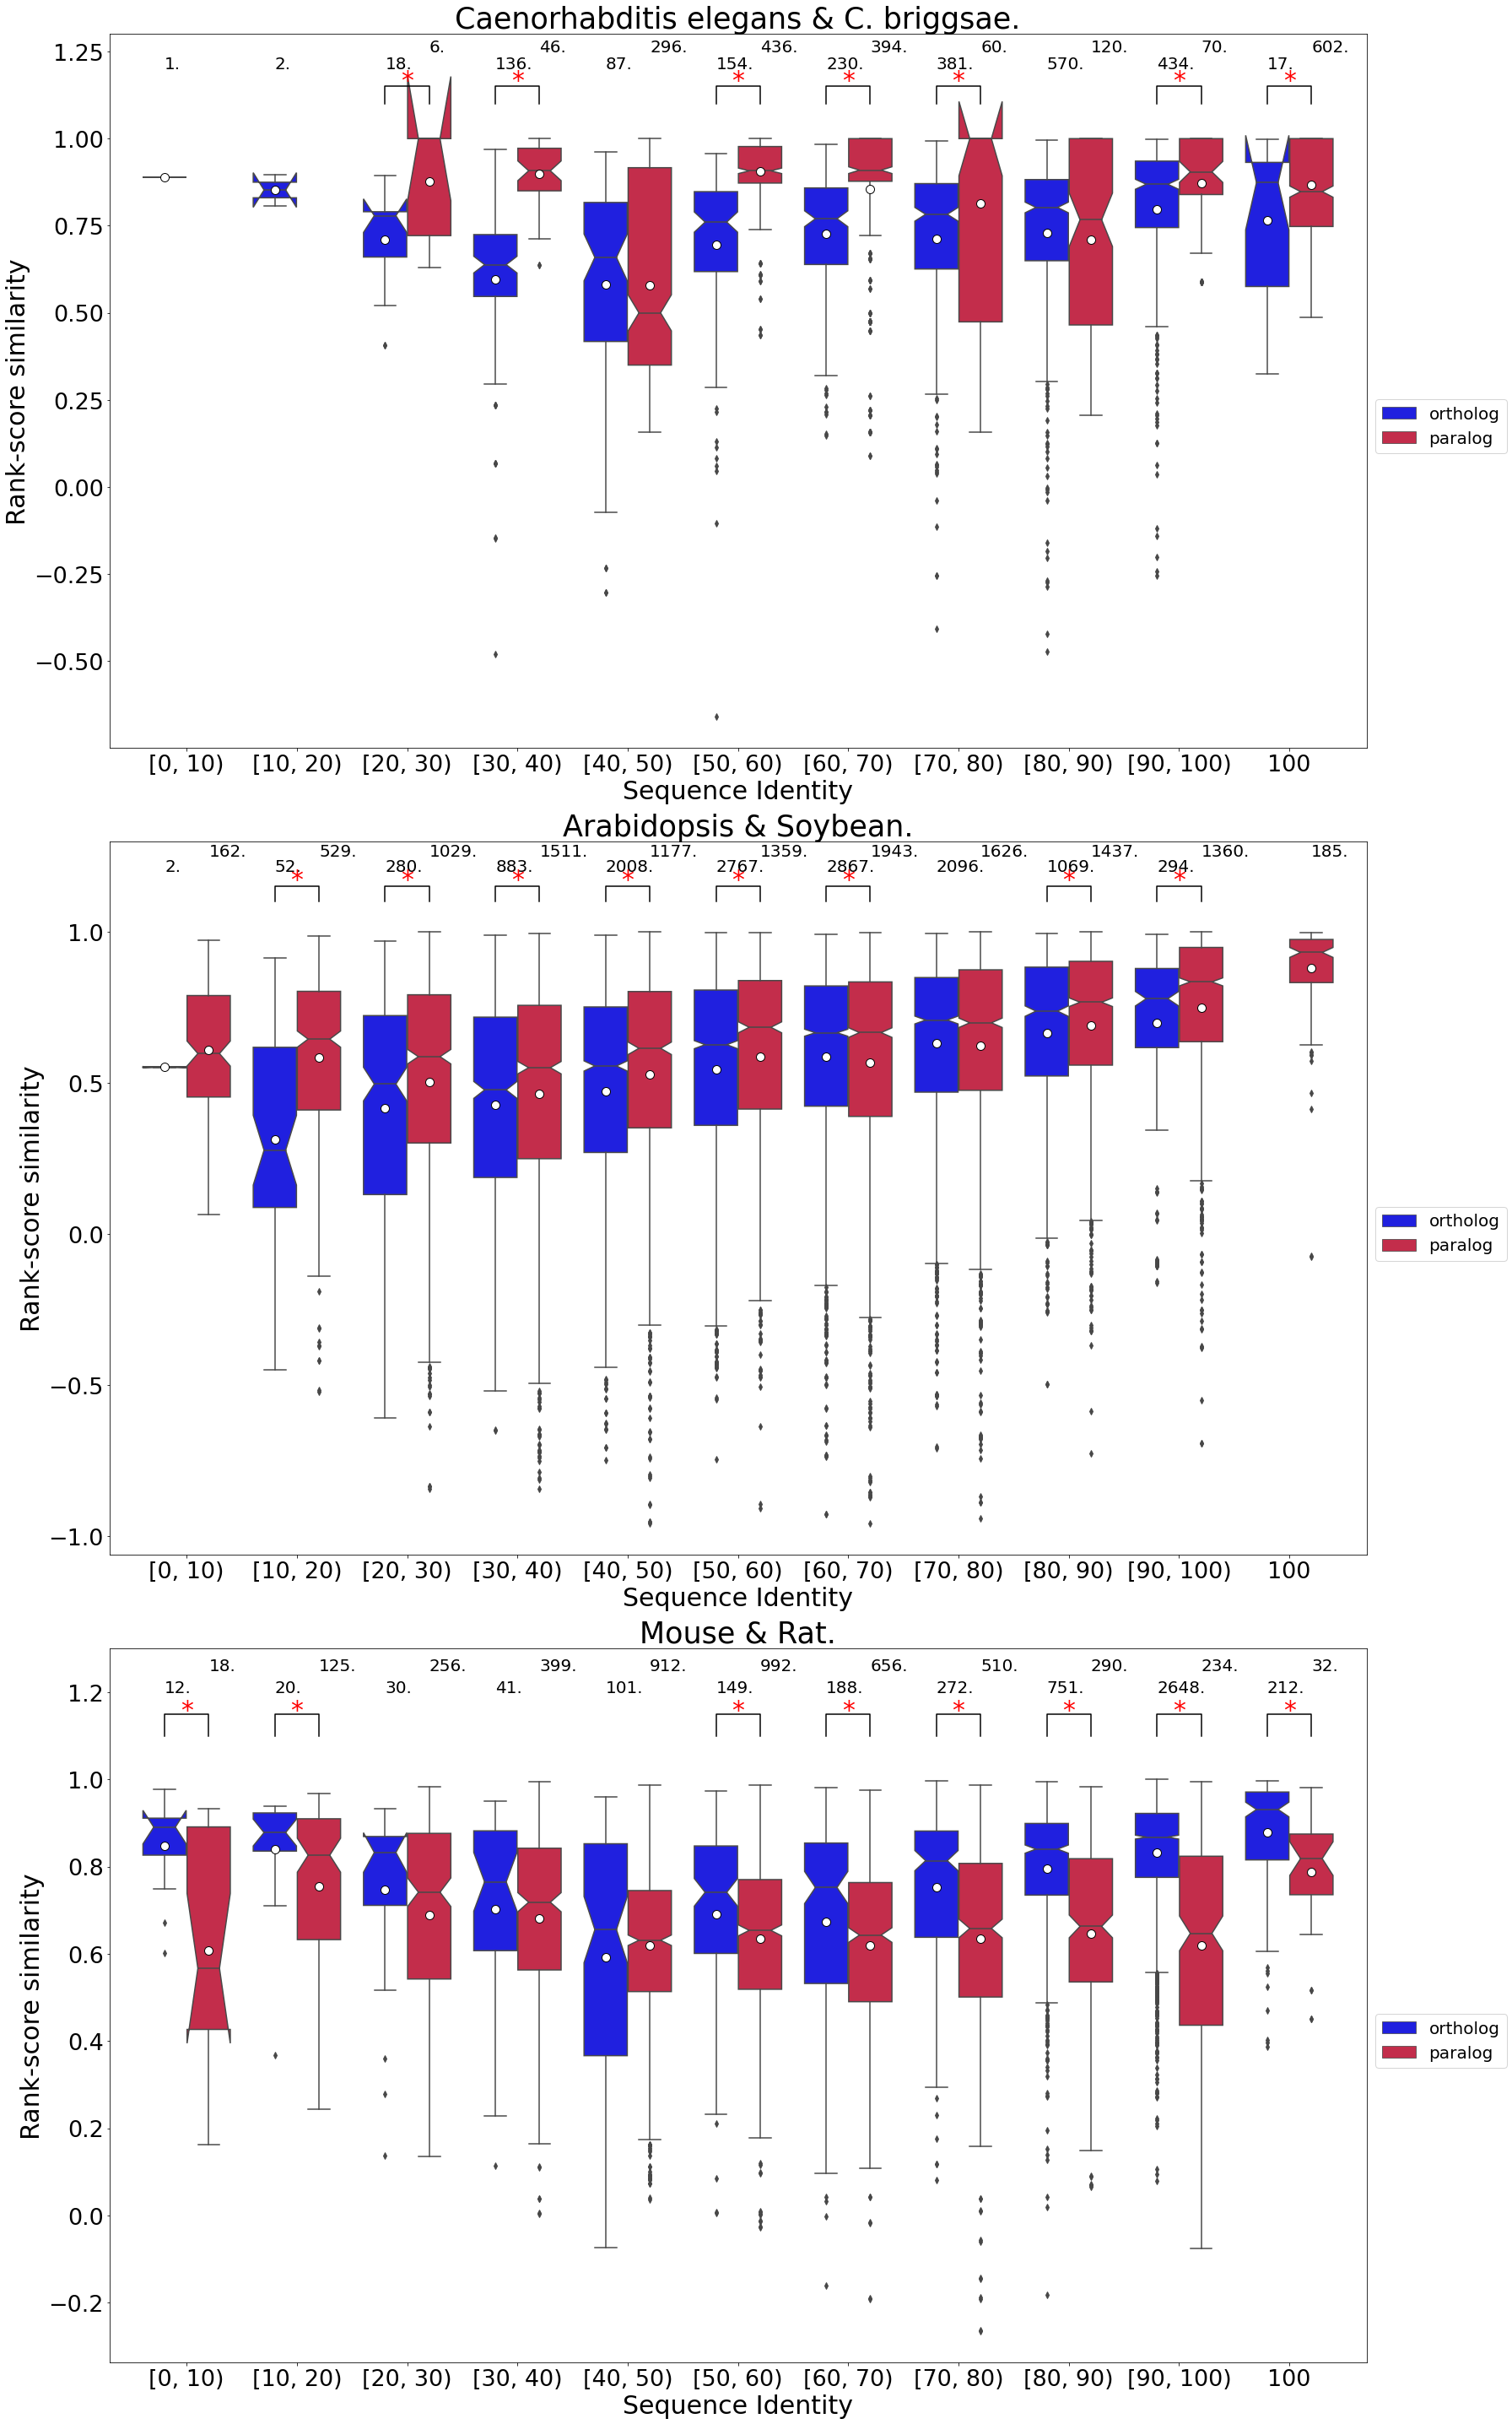

In [25]:
#Plot the relationship of expression correlations and sequence identity:
file_names=['summary_be.tsv', 'summary_ag.tsv', 'summary_soellner.tsv']
titles = [', Caenorhabditis elegans & C. briggsae.', ', Arabidopsis & Soybean.',  ', Mouse & Rat.']
counter = 0
fig=plt.figure(figsize=(25, 40))
for j in range(len(file_names)):
    #print(file_names[j])
    plt.subplot(3, 1, counter + 1)   
    plot_group_boxplot_xy(file_names[j], 'seq_iden', 'Sequence Identity', 'r_sim', 'Rank-score similarity', titles[j], False)
    counter += 1
    #print('---------------------------')
    #print()
fig.tight_layout()
plt.savefig('r_sim_seq_iden_first3.png')
    

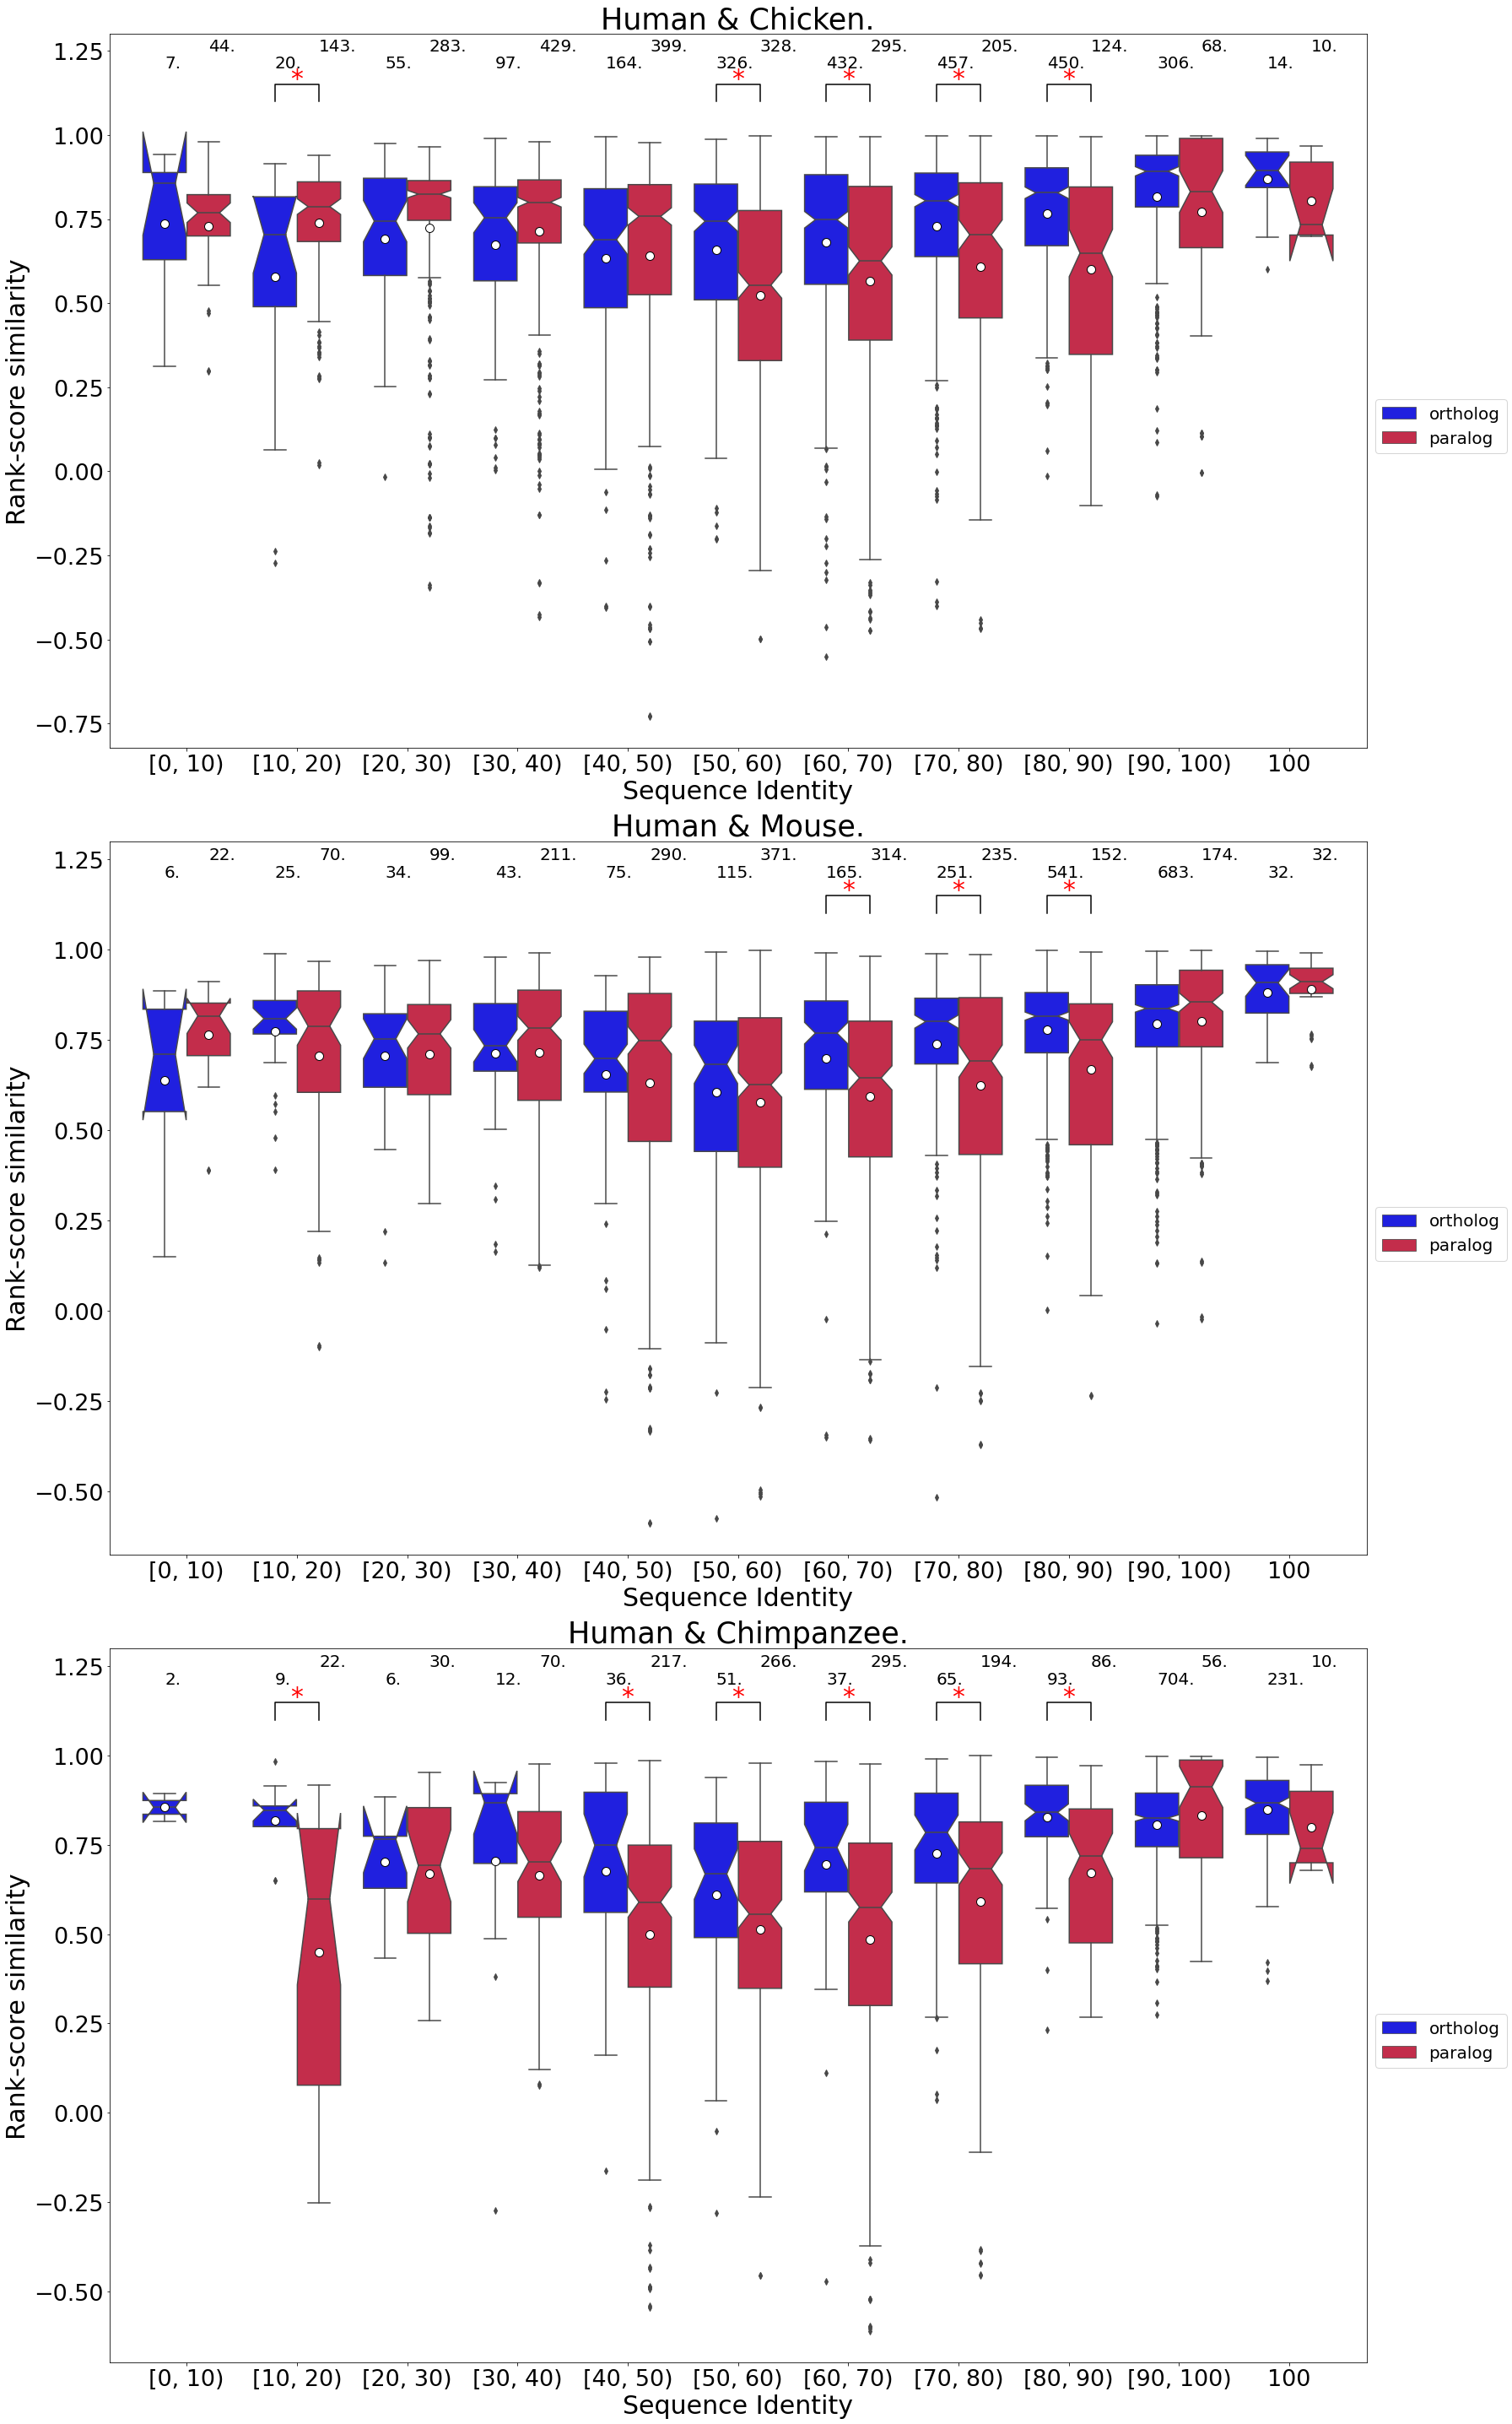

In [27]:
#Plot the relationship of expression correlations and sequence identity:
file_names=['summary_hg.tsv', 'summary_hm.tsv', 'summary_hc.tsv']
titles = [', Human & Chicken.', ', Human & Mouse.',  ', Human & Chimpanzee.']
counter = 0
fig=plt.figure(figsize=(25, 40))
for j in range(len(file_names)):
    plt.subplot(3, 1, counter + 1)   
    #print(file_names[j])
    plot_group_boxplot_xy(file_names[j], 'seq_iden', 'Sequence Identity', 'r_sim', 'Rank-score similarity', titles[j], False)
    counter += 1
    #print('---------------------------------')
    #print()
fig.tight_layout()
plt.savefig('r_sim_seq_iden_brawand.png')

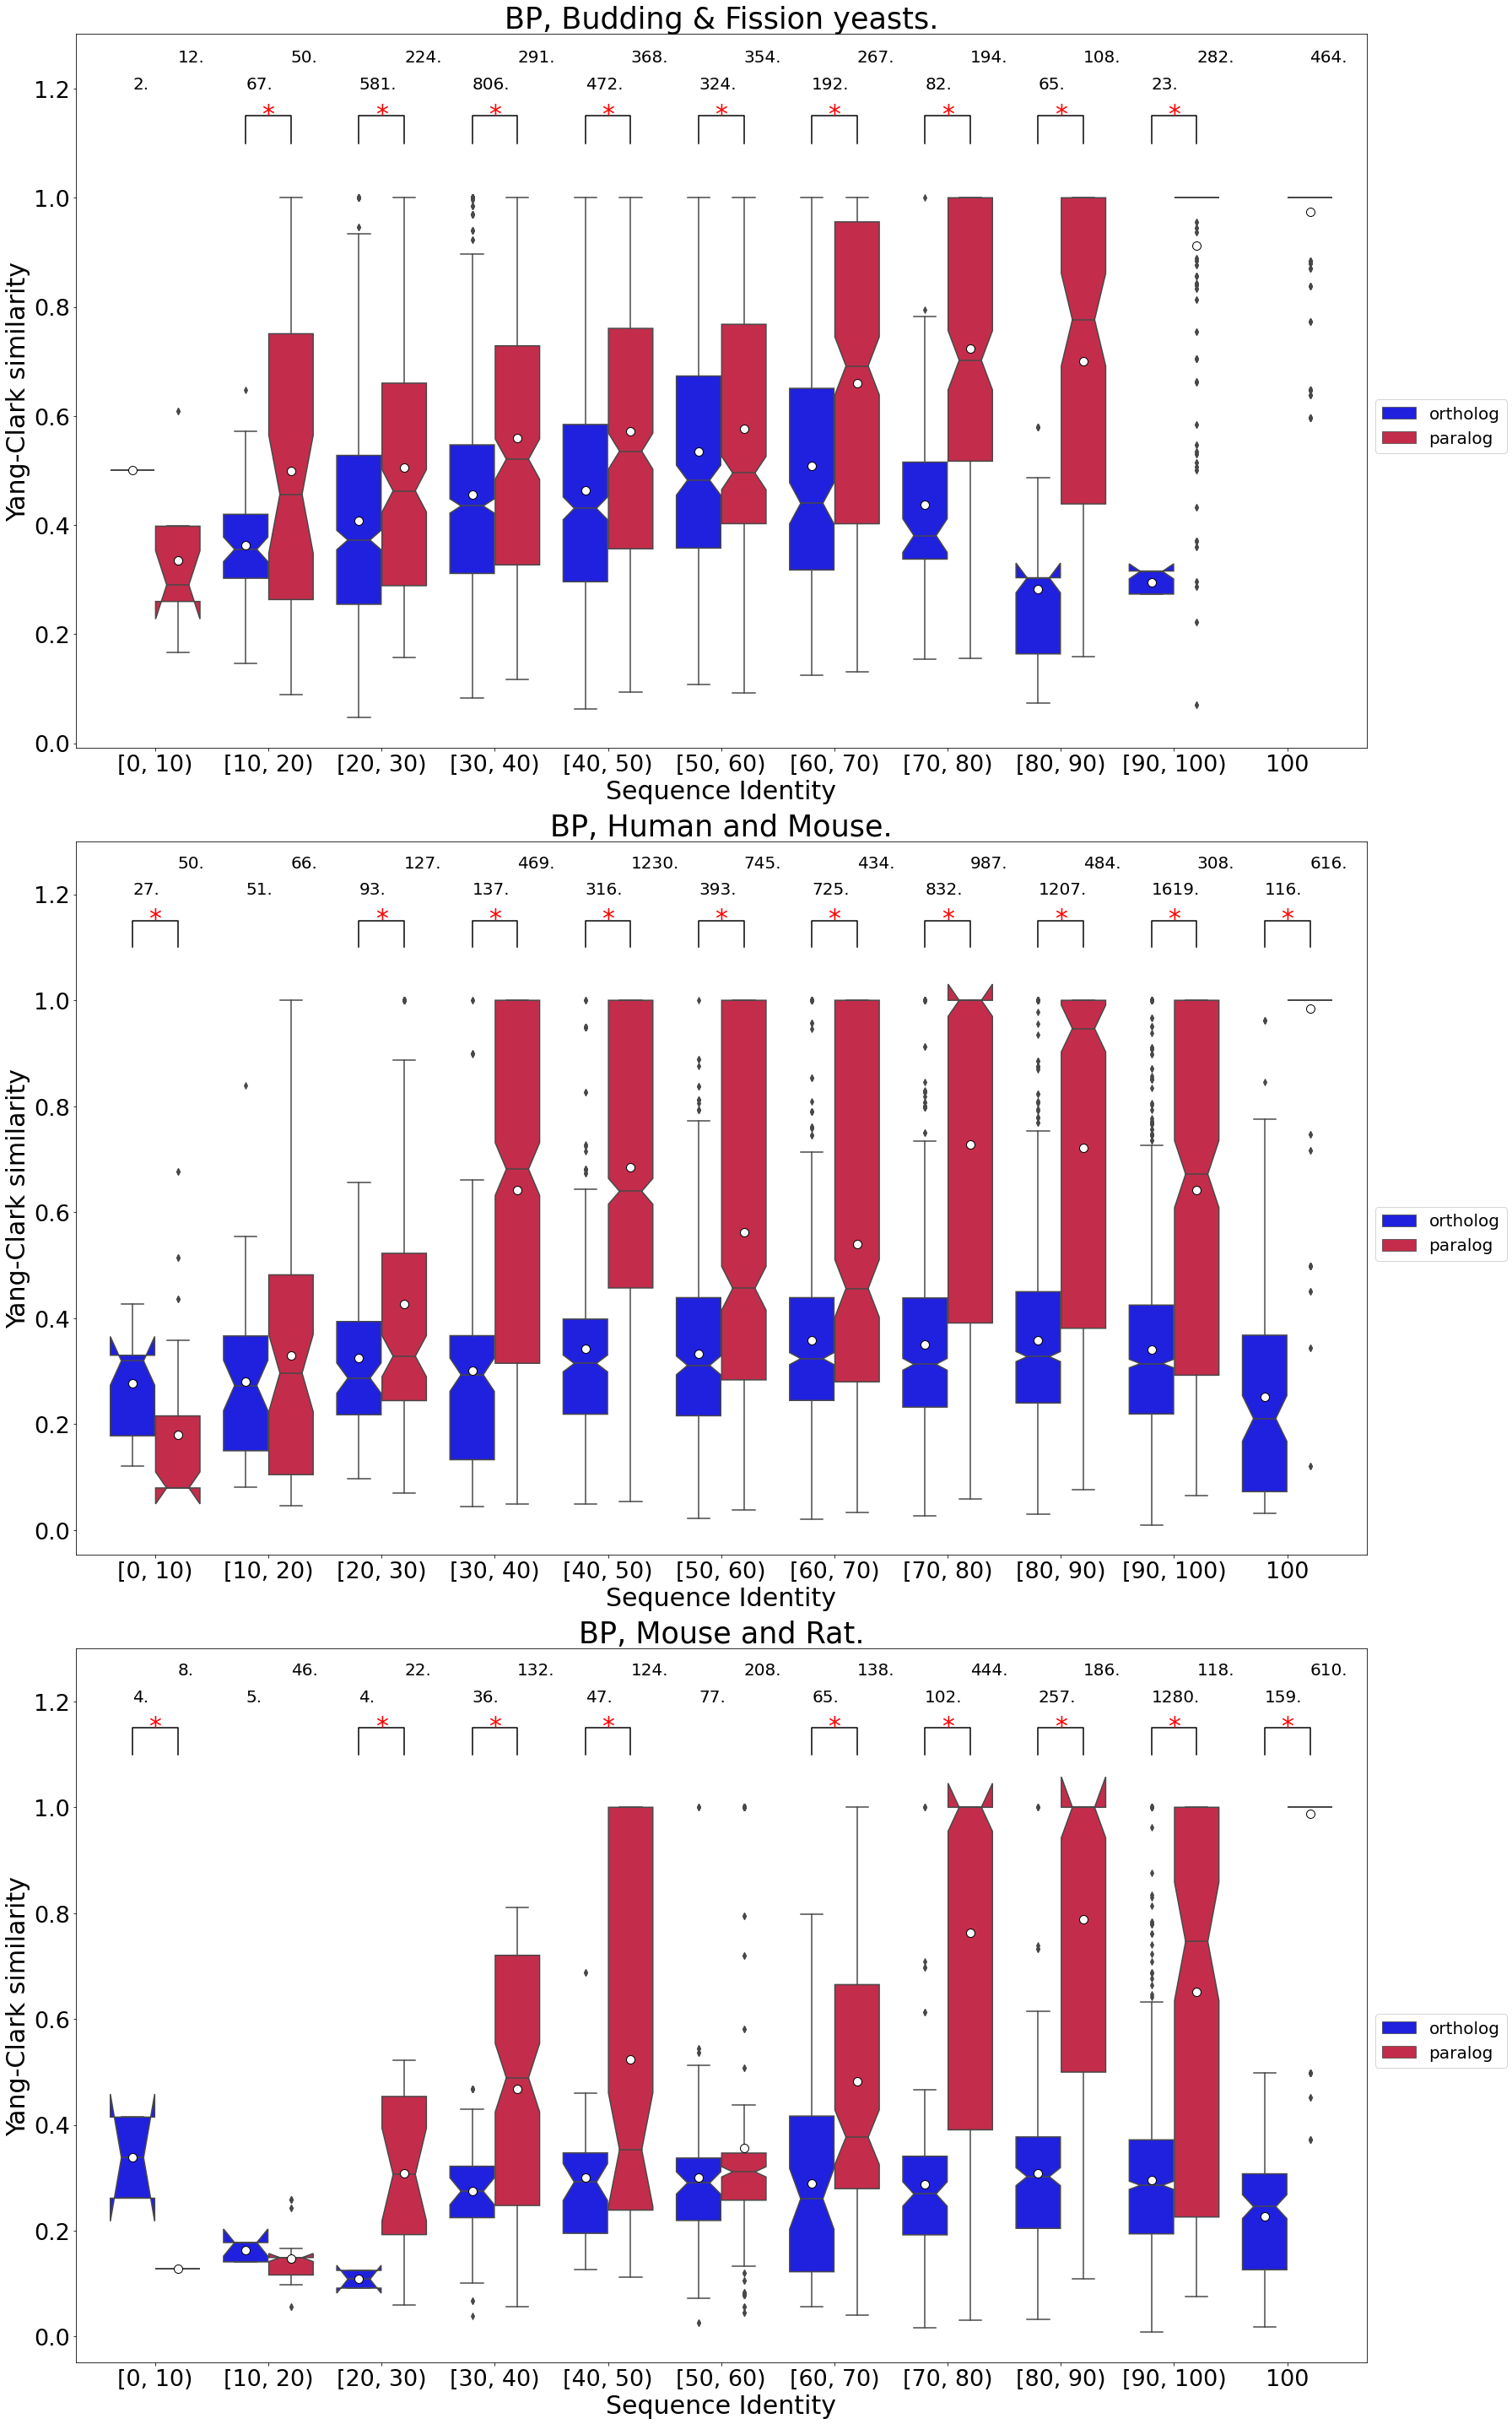

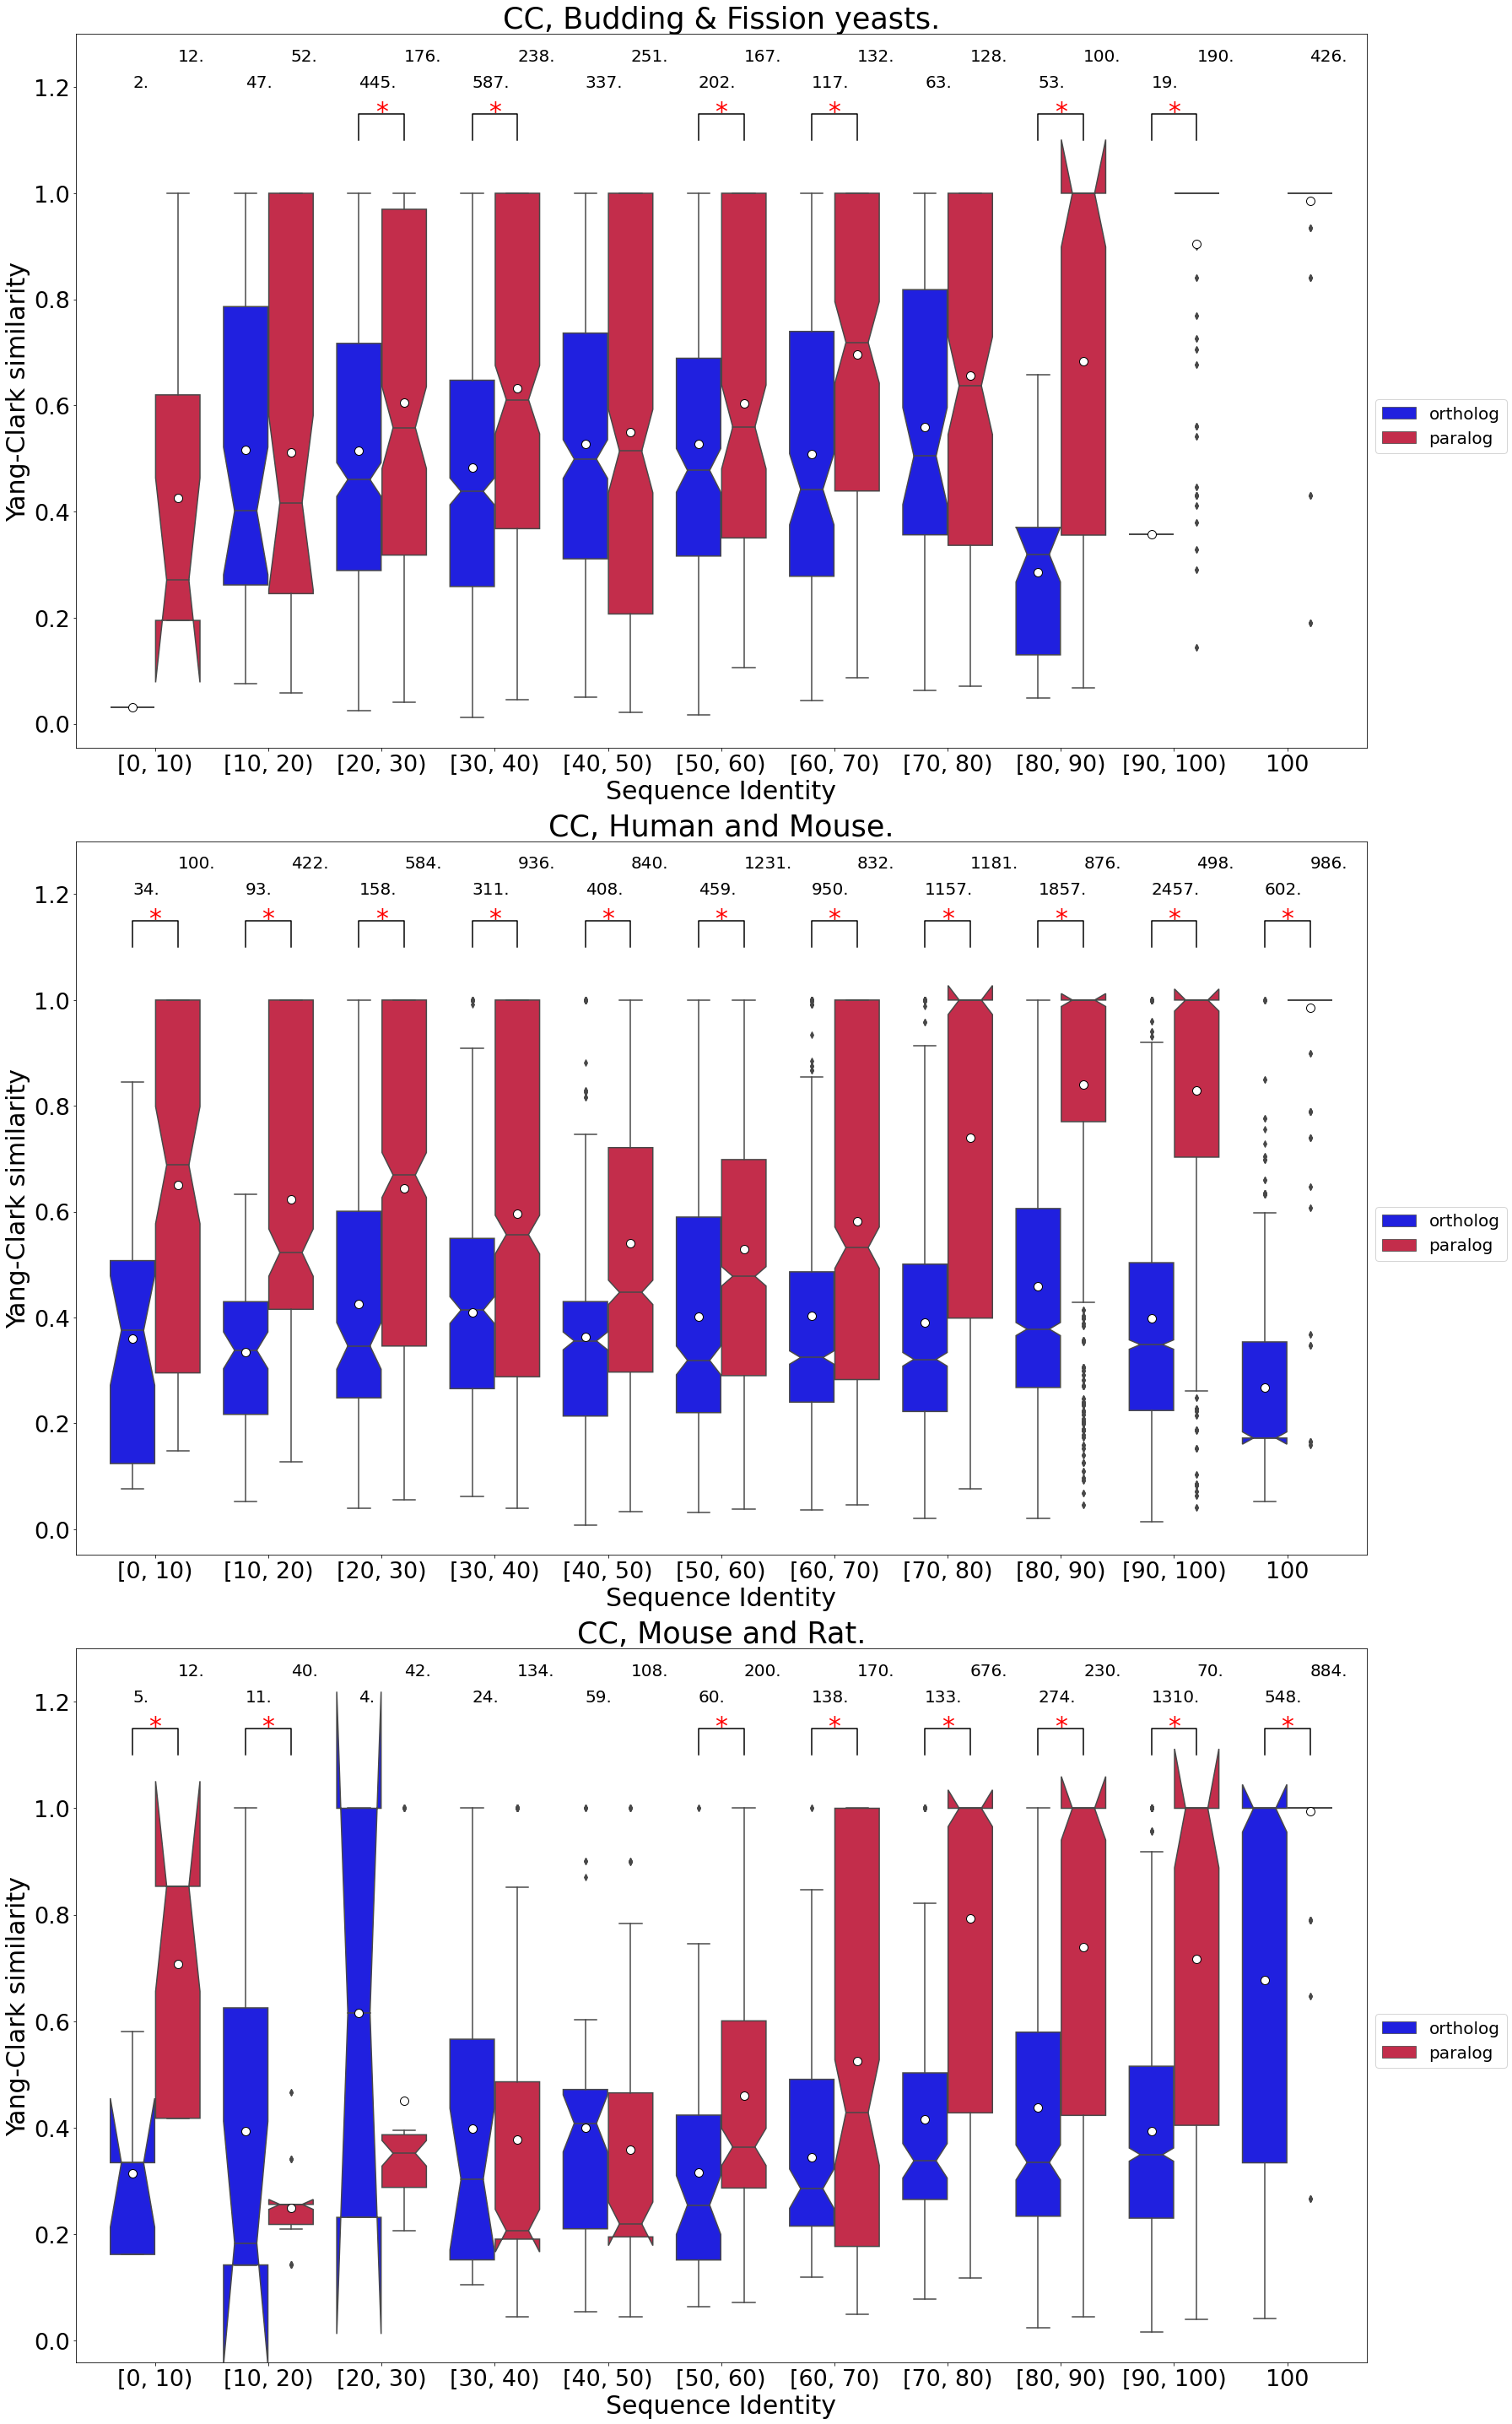

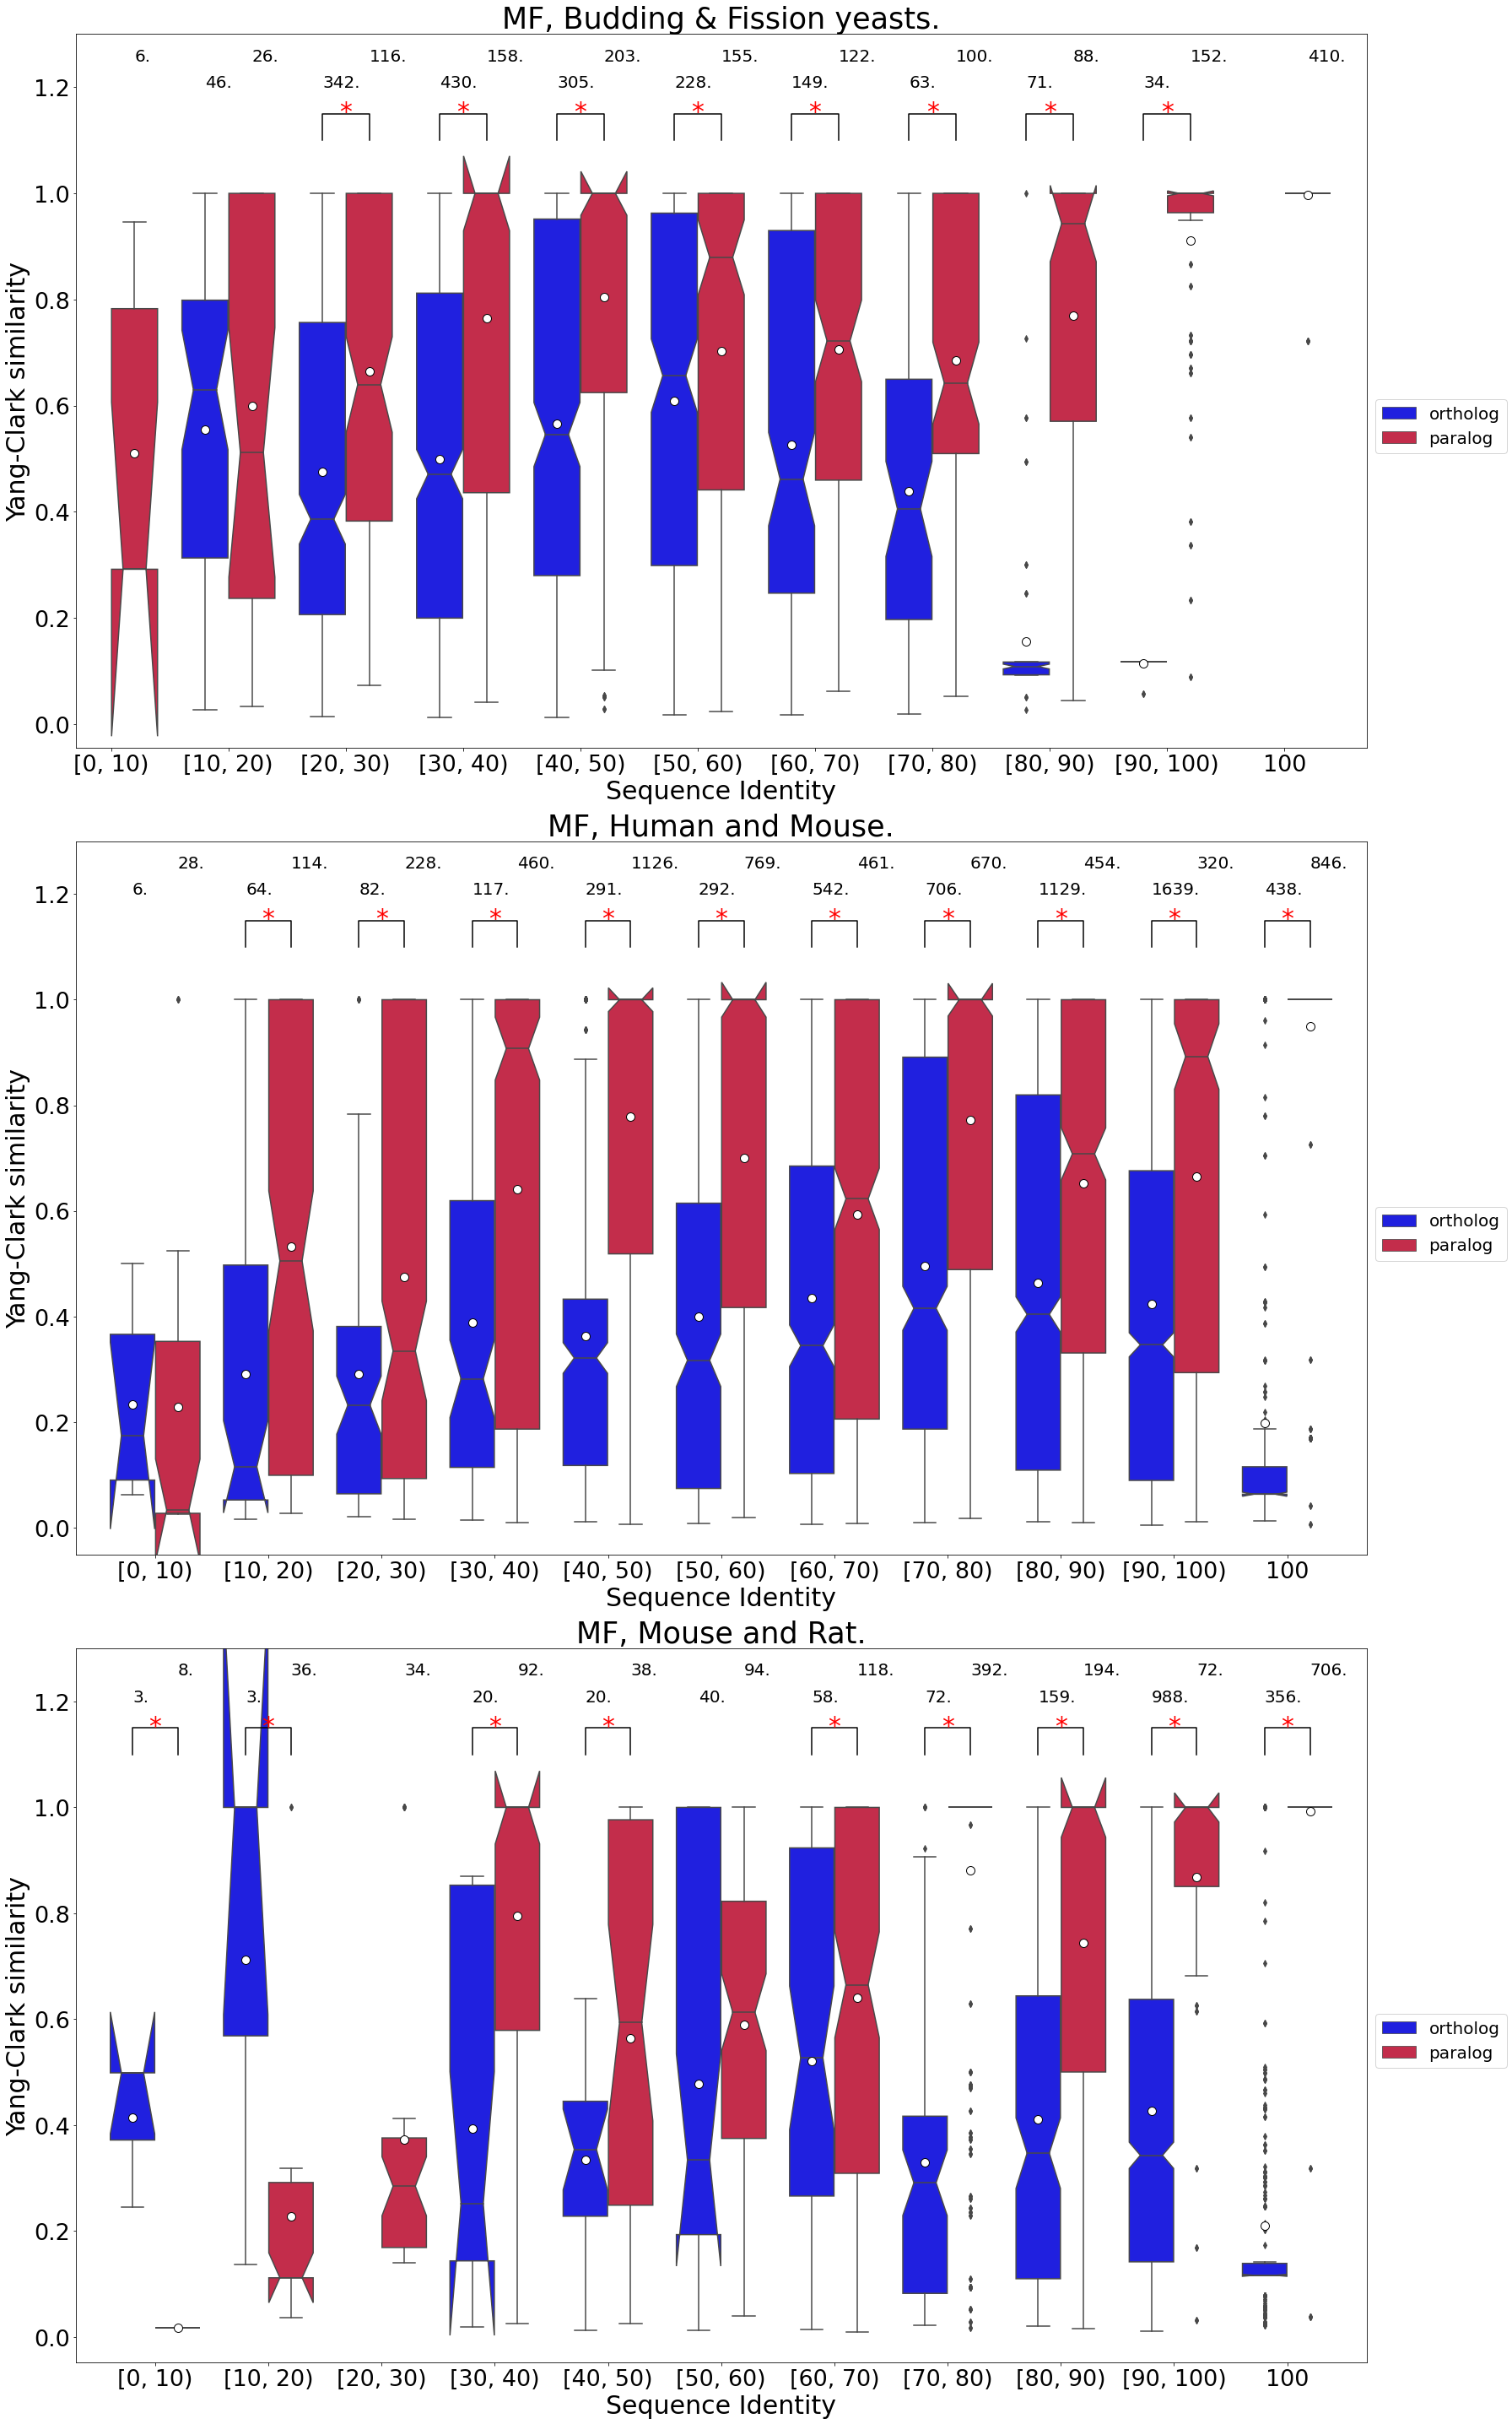

In [28]:
#Plot the relationship of Yang-Clark similarity and sequence identity:
file_names = ['summary_gos_cp_', 'summary_gos_hm_', 'summary_gos_mr_']
titles = [', Budding & Fission yeasts.', ', Human and Mouse.', ', Mouse and Rat.']
ancs = ['bp', 'cc', 'mf']
ancs_titles = ['BP', 'CC', 'MF']

for j in range(len(ancs)):
    fig=plt.figure(figsize=(25, 40))
    counter = 0
    for i in range(len(file_names)):
        plt.subplot(3, 1, counter + 1)
        #print(file_names[i]+ancs[j]+'.tsv')
        plot_group_boxplot_xy(file_names[i]+ancs[j]+'.tsv', 'seq_iden', 'Sequence Identity', 'yc_sim', 'Yang-Clark similarity', ancs_titles[j] +titles[i], True)
        counter += 1
        #print('-------------------------------')
        #print()
    fig.tight_layout()
    plt.savefig('yc_sim_seq_iden_'+ancs[j]+ '.png')
    

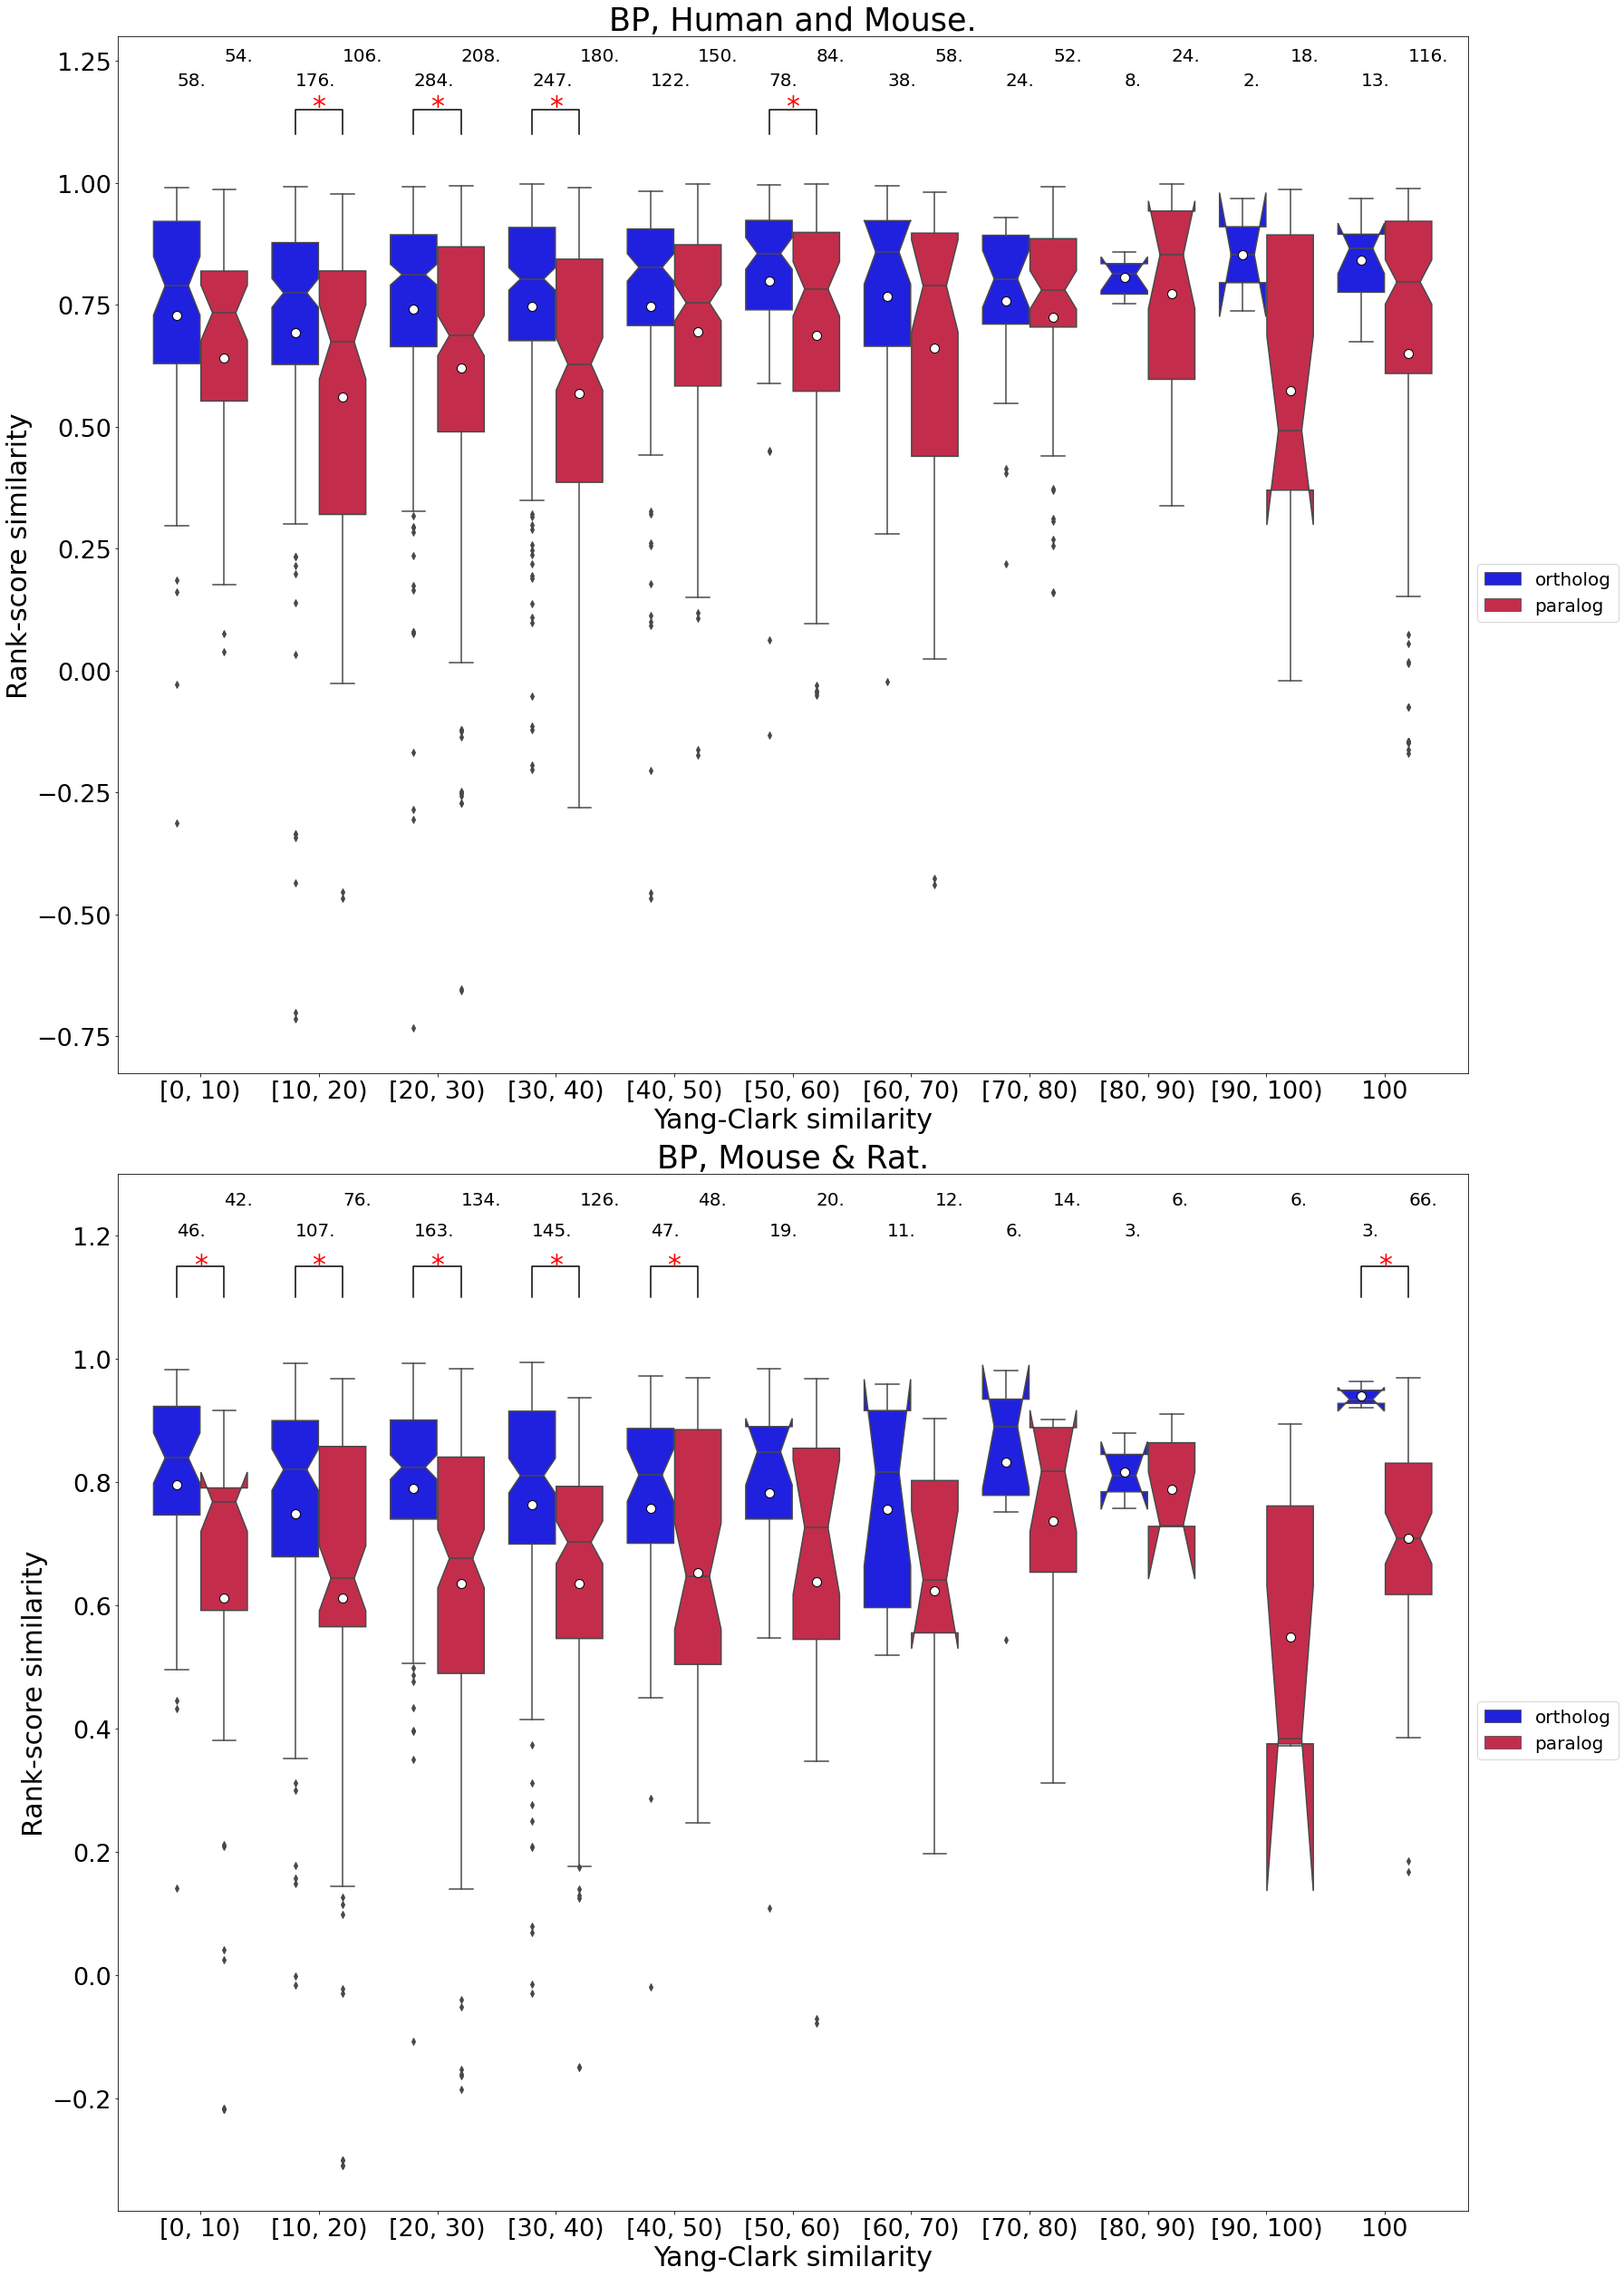

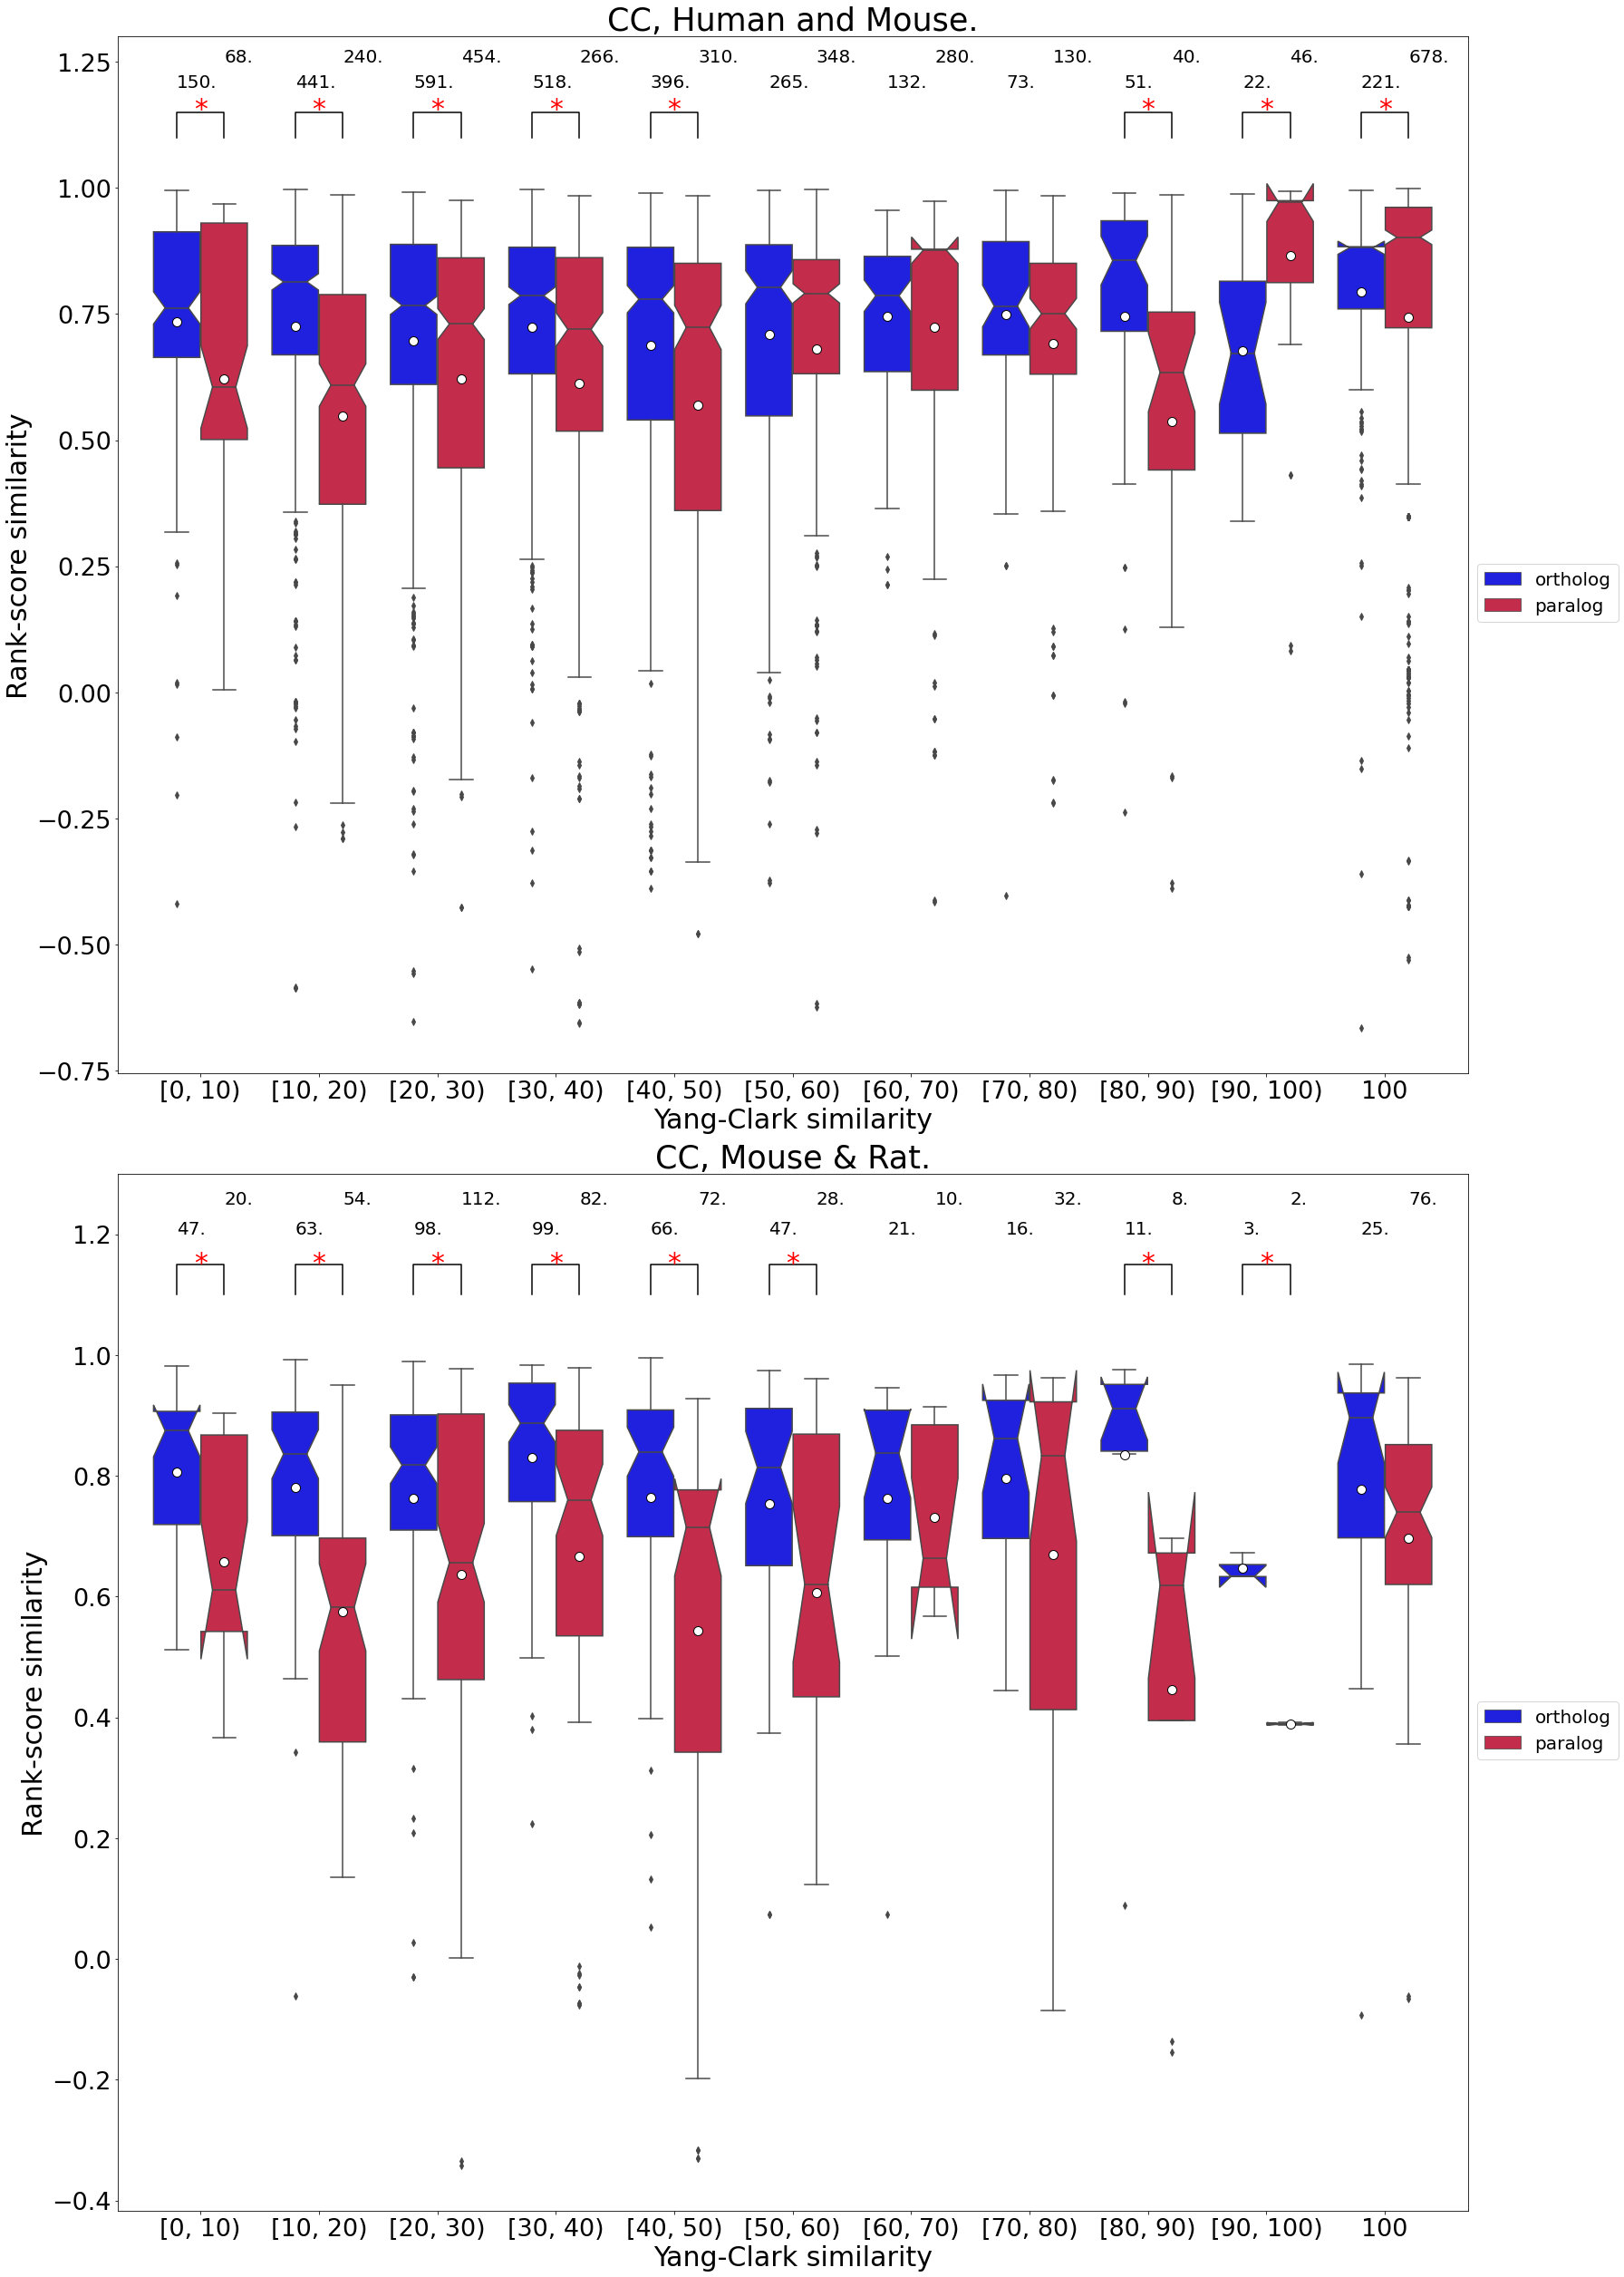

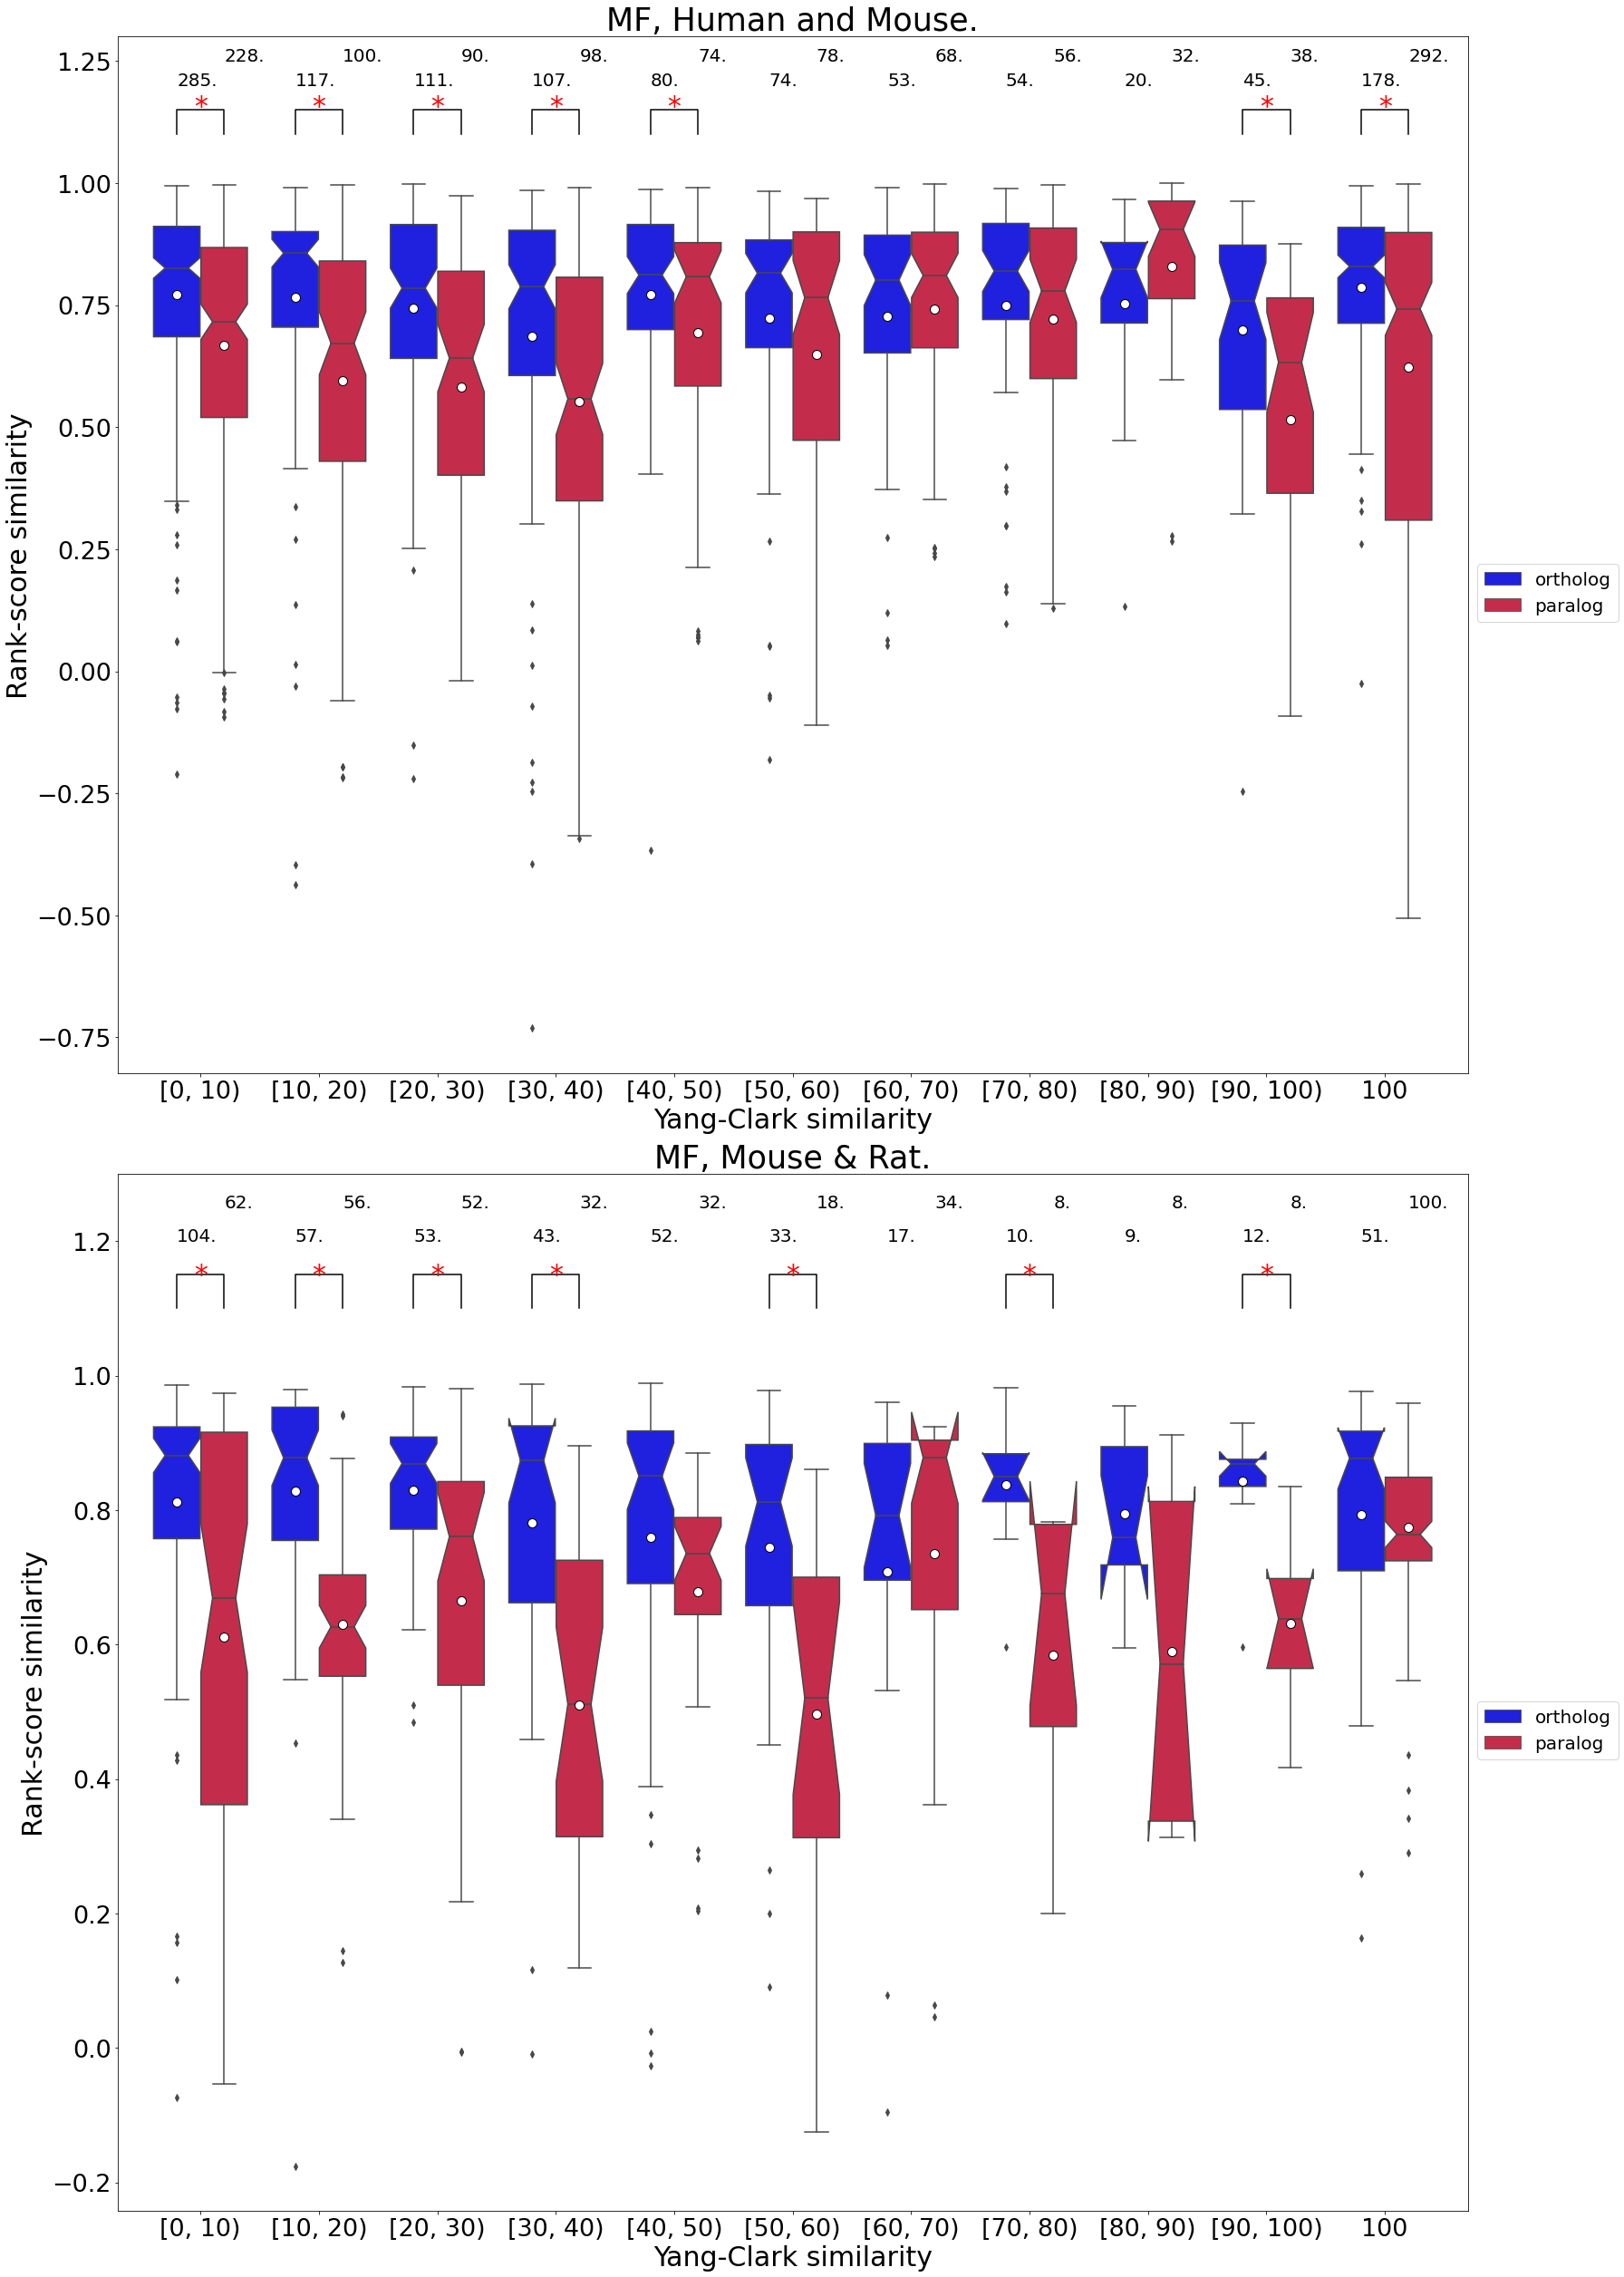

In [29]:
#Plot the relationship between the Rank-score similarity and Yang-Clark similarity.
file_names = ['summary_expr_go_human_mouse_', 'summary_expr_go_mouse_rat_soellner_']
titles = [ ', Human and Mouse.', ', Mouse & Rat.']
ancs = ['bp', 'cc', 'mf']
ancs_titles = ['BP', 'CC', 'MF']

for j in range(len(ancs)):
    fig=plt.figure(figsize=(25, 35))
    counter = 0
    for i in range(len(file_names)):
        plt.subplot(2, 1, counter + 1)
        #print(file_names[i]+ancs[j]+'.tsv')
        plot_group_boxplot_xy(file_names[i]+ancs[j]+'.tsv', 'yc_sim', 'Yang-Clark similarity', 'r_sim', 'Rank-score similarity', ancs_titles[j] +titles[i], True)
        counter += 1
        #print('-------------------------------')
        #print()
    fig.tight_layout()
    plt.savefig('r_sim_yc_sim_'+ancs[j]+ '.png')